In [140]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import time
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')


In [141]:
class Run:
    def __init__(self, file, nevents):
        self.file = Path(file) 
        self.nevents = nevents

        # Root file variables 
        self.meta_data = None
        self.output_data = None

        # Is Online
        self.pmt_is_online = None 

        # Hit cleaning masks
        self.hit_amp_cut = None
        self.hit_charge_cut = None
        self.hit_time_cut = None        

        # Hit cleaning settings
        self.time_cut = [-20, 20]  # ns
        self.amp_cut = 3

        # Hit cleaned data
        self.clean_charges = None
        self.clean_nhit = None

        # Event selection masks 
        self.prompt_raw_mask = None
        self.delayed_raw_mask = None 
        self.prompt_clean_mask = None 
        self.delayed_clean_mask = None 

        # Event selected data
        self.delayed_dt = None
        self.delayed_dt_mask = None 
        self.final_event_mask = None 
        self.final_charges = None 

        # Timing variables for plotting
        self.clock_period = 0.5  # us
        self.start_time = 1 #3 * 0.432 + self.clock_period # 0  # e.g., 0.864 us
        self.nclock_cycles_to_plot = 40
        self.stop_time = self.start_time + (self.nclock_cycles_to_plot) * self.clock_period  # e.g., 0.912

        # PMT ids for plotting  
        self.barrel_ids = None 
        self.bottom_ids = None 
        self.dichroic_ids = None 
        self.top_ids = None 
        self.behind_ids = None 

    def print_nevents_in_file(self):
        f = up.open(self.file)
        print(f"There are {f['output'].num_entries} events in {self.file}")

    def load_meta_data(self):
        f = up.open(self.file)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time() 
        self.meta_data = f['meta'].arrays([
            'pmtType',
            'pmtId',
            'pmtChannel',
            'pmtIsOnline',
            'pmtCableOffset',
        ], entry_start=0, entry_stop=self.nevents, library='ak') 
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load meta data for {self.nevents} events")

    def load_event_data(self):
        f=up.open(self.file)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timestamp',
            'timeSinceLastTrigger_us',
            'digitPMTID',
            'digitTime',
            'digitCharge',
            'digitPeak',
            'digitNegativePeak',
            'x_quadfitter',
            'y_quadfitter',
            'z_quadfitter',
            'time_quadfitter',
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load output data for {self.nevents} events")

    # step 1
    def apply_hit_cleaning(self):
        # Make hit amplitude ratio hit cut
        digit_peak = self.output_data['digitPeak']
        digit_neg_peak = self.output_data['digitNegativePeak']
        ratio = digit_peak / digit_neg_peak
        hit_amp_cut = ratio > self.amp_cut

        # Make positive charge hit cut 
        charges = self.output_data['digitCharge']
        hit_charge_cut = charges > 0

        # Make time cut
        times = self.output_data['digitTime']
        event_times = self.output_data['time_quadfitter']
        event_times = ak.broadcast_arrays(times, event_times)[1]
        times = times - event_times
        cut = self.time_cut
        hit_time_cut = (times > cut[0]) & (times < cut[1])

        # Save important stuff
        self.hit_amp_cut = hit_amp_cut
        self.hit_charge_cut = hit_charge_cut
        self.hit_time_cut = hit_time_cut


    # step 2
    def make_nhit_masks(self):

        # Get raw data
        charges = self.output_data['digitCharge']

        # Apply hit cuts individually for diagnostics   
        amp_charges = ak.mask(charges, self.hit_amp_cut)
        charge_charges = ak.mask(charges, self.hit_charge_cut) # don't use this anymore, encapulates in amp cut
        time_charges = ak.mask(charges, self.hit_time_cut)

        # Apply all hit cuts together
        clean_charges = ak.mask(charges, self.hit_amp_cut & self.hit_time_cut)

        # Calculate NHits
        raw_nhit = ak.count(charges, axis=1)
        amp_nhit = ak.count(amp_charges, axis=1)
        time_nhit = ak.count(time_charges, axis=1)
        clean_nhit = ak.count(clean_charges, axis=1)

        # Save important stuff
        self.clean_charges = clean_charges
        self.clean_nhit = clean_nhit

        # Flatten charges for plotting
        charges = ak.to_numpy(ak.flatten(charges))
        amp_charges = ak.to_numpy(ak.flatten(amp_charges))
        time_charges = ak.to_numpy(ak.flatten(time_charges))
        clean_charges = ak.to_numpy(ak.flatten(clean_charges))

        # Make trigger type masks 
        prompt_min_nhit = 125
        delayed_min_nhit = 50
        prompt_raw_mask = raw_nhit >= prompt_min_nhit
        delayed_raw_mask = (raw_nhit >= delayed_min_nhit) & (raw_nhit < prompt_min_nhit)
        prompt_clean_mask = clean_nhit >= prompt_min_nhit
        delayed_clean_mask = (clean_nhit >= delayed_min_nhit) & (clean_nhit < prompt_min_nhit)

        # Save important stuff
        self.prompt_clean_mask = prompt_clean_mask 
        self.delayed_clean_mask = delayed_clean_mask
        self.prompt_raw_mask = prompt_raw_mask 
        self.delayed_raw_mask = delayed_clean_mask

        # For diagnostics and labeling the plot
        raw_prompt = ak.count(ak.mask(raw_nhit, prompt_raw_mask), axis=None)
        raw_delayed = ak.count(ak.mask(clean_nhit, delayed_raw_mask), axis=None)
        clean_prompt = ak.count(ak.mask(clean_nhit, prompt_clean_mask), axis=None)
        clean_delayed = ak.count(ak.mask(clean_nhit, delayed_clean_mask), axis=None)

        # Plot NHits
        max_nhit=200
        fontsize=20
        plt.figure(figsize=(10,5))
        plt.hist(raw_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='black',label=f"Raw data")#: {raw_prompt} prompt {raw_delayed} delayed");
        plt.hist(amp_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='green',label=f"After amplitude hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(time_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='orange',label=f"After time hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(clean_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='purple',label=f"After amplitude + time hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.title('EOS Run 3056 (Water Fill)',fontsize=fontsize)
        plt.xlabel('NHits',fontsize=fontsize)
        plt.ylabel('Number of Events',fontsize=fontsize)
        #plt.axvspan(125,200,color='blue',alpha=0.1,label='Stopping Muon Candidates')
        #plt.axvspan(50,125,color='red',alpha=0.1,label='Michel Electron Candidates')
        plt.semilogy()
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor=(2.5,1))

        # Plot total charge
        charge_range = (-10,10)
        plt.figure(figsize=(10,5))
        plt.hist(charges,bins=max_nhit,range=charge_range,histtype='step',color='black',label=f"Raw data")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(amp_charges,bins=max_nhit,range=charge_range,histtype='step',color='green',label=f"After amplitude hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(time_charges,bins=max_nhit,range=charge_range,histtype='step',color='orange',label=f"After time hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.hist(clean_charges,bins=max_nhit,range=charge_range,histtype='step',color='purple',label=f"After amplitude + time hit cut")#: {clean_prompt} prompt {clean_delayed} delayed");
        plt.title('EOS Run 3056 (Water Fill)',fontsize=fontsize)
        plt.xlabel('Digit Charge [pC]',fontsize=fontsize)
        plt.ylabel('Number of Events',fontsize=fontsize)
        plt.semilogy()
        plt.legend(ncol=1,loc='upper right',bbox_to_anchor=(2.5,1))




    # step 3
    def compute_delayed_times_relative_to_prompt_with_ts(self):

        prompt_mask = self.prompt_clean_mask
        delayed_mask = self.delayed_clean_mask

        timestamps = self.output_data['timestamp']
        timestamps = np.asarray(timestamps)
        prompt_times = timestamps[prompt_mask]
        delayed_times = timestamps[delayed_mask]

        delta_ts = []
        i_prompt = 0

        for delayed_time in delayed_times:
            # Advance through prompt_times as long as they're in the past
            while i_prompt + 1 < len(prompt_times) and prompt_times[i_prompt + 1] < delayed_time:
                i_prompt += 1

            if prompt_times[i_prompt] < delayed_time:
                delta_ts.append(delayed_time - prompt_times[i_prompt])

            else:
                # No prior prompt found (e.g., delayed event came before all prompts)
                delta_ts.append(np.nan)

        self.delayed_dt = np.array(delta_ts)

    # step 4
    def make_deliverables(self):

        dt_clean = self.delayed_dt
        delayed_clean_mask = self.delayed_clean_mask
        clean_charges = self.clean_charges

        print(len(dt_clean),dt_clean)
        print(len(delayed_clean_mask),delayed_clean_mask)

        # Apply delay time cut (dt < 3 µs) to delayed events
        time_mask = (self.start_time < dt_clean/1e3) & (dt_clean/1e3 <= self.stop_time)   # [delayed events only]

        print(len(time_mask),time_mask)
        
        # Select only delayed events that passed the time cut
        # delayed_amp_time_mask is [all events] — we now filter that with time_mask
        final_event_mask = ak.Array(delayed_clean_mask)  # shape: [events]
        # Get indices of delayed events
        delayed_indices = ak.where(delayed_clean_mask)[0]  # np.array of indices
        # Apply time cut
        valid_delayed_indices = delayed_indices[time_mask]  # np.array of surviving delayed event indices
        
        # Now build final event-level mask
        final_event_mask = np.zeros(len(delayed_clean_mask), dtype=bool)
        final_event_mask[valid_delayed_indices] = True  # shape: [event]

        print(len(final_event_mask),final_event_mask)
        
        # Final cleaned arrays (hits within selected delayed events)
        digit_charge_final = clean_charges[final_event_mask]


        # Save important stuff
        self.delayed_dt_mask = time_mask
        self.final_event_mask = final_event_mask
        self.final_charges = digit_charge_final


    def make_coincident_hits(self):

        final_event_mask = self.final_event_mask

        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0]

        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
        id2board = dict(zip(ch2id.values(), [ch//16 for ch in ch2id.keys()]))

        digit_ids = self.output_data['digitPMTID']

        print(range)

        # Define PMT channels
        barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
        barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]

        special_channels = np.arange(0, 36, 1)

        top_boards =  [12, 13]
        top_channels = [16 * board + i for board in top_boards for i in range(16)]

        dichroic_boards = [7]
        dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

        bottom_boards = [14, 15]
        bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

        behind_boards = [16]
        behind_channels = [16 * board + i for board in behind_boards for i in range(13)]


        # Convert channel lists to ID lists
        barrel_ids = [ch2id[ch] for ch in barrel_channels if ch in ch2id]
        bottom_ids = [ch2id[ch] for ch in bottom_channels if ch in ch2id]
        dichroic_ids = [ch2id[ch] for ch in dichroic_channels if ch in ch2id]
        special_ids = [ch2id[ch] for ch in special_channels if ch in ch2id]
        top_ids = [ch2id[ch] for ch in top_channels if ch in ch2id]
        behind_ids = [ch2id[ch] for ch in behind_channels if ch in ch2id]
    
        # Should really do a fiducial cut for x,y,z
        pos_min = -600
        pos_max = 600
        
        x_fit = self.output_data['x_quadfitter']
        x_mask = (x_fit > pos_min) & (x_fit < pos_max)
        
        y_fit = self.output_data['y_quadfitter']
        y_mask = (y_fit > pos_min) & (y_fit < pos_max)

        z_fit = self.output_data['z_quadfitter']
        z_mask = (z_fit > pos_min) & (z_fit < pos_max)

        pos_final_event_mask = final_event_mask & x_mask & y_mask & z_mask
        
        
        # Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
        pmt_hit_counts = np.zeros(np.max(pmt_chs)+1, dtype=int)
        
        clean_ids = self.output_data['digitPMTID'][self.hit_amp_cut & self.hit_charge_cut & self.hit_time_cut]
        clean_ids = clean_ids[pos_final_event_mask]
        nevents = len(clean_ids)
        print(nevents)
        
        # Flatten clean PMT IDs
        flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
        flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])
        
        # Use np.bincount to count hits per LCN (assuming pmt_ch == LCN)
        pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)
        
        
        # Normalize to hits per Michel candidate (optional)
        coinc_hit_counts = pmt_hit_counts / nevents 
        coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents

        # Save important stuff
        self.barrel_channels = barrel_channels
        self.bottom_channels = bottom_channels
        self.dichroic_channels = dichroic_channels
        self.top_channels = top_channels
        self.behind_channels = behind_channels

        self.coinc_hit_counts = coinc_hit_counts
        self.coinc_hit_err = coinc_hit_err


        # Make PMT is online for sim 

        # Find LCNs with nonzero hits
        active_lcns = np.nonzero(coinc_hit_counts)[0]

        # Convert active LCNs to PMT IDs using your mapping
        active_ids = [ch2id[lcn] for lcn in active_lcns if lcn in ch2id]

        # Build boolean mask of size [n_total_pmts], True if that PMT ID is active
        n_pmts = max(ch2id.values()) + 1  # or use len(pmt_is_online) if already known
        pmt_is_online = np.zeros(n_pmts, dtype=bool)
        pmt_is_online[active_ids] = True

        self.pmt_is_online = pmt_is_online

    def plot_dichroic_occupancy_vs_z(self, nbins=20):
        import matplotlib.pyplot as plt
        import numpy as np
        import awkward as ak       
        pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)

    
        # Channel to PMT id maps
        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0]
        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
    
        # Fiducial cuts
        x_fit = self.output_data['x_quadfitter']
        y_fit = self.output_data['y_quadfitter']
        z_fit_all = self.output_data['z_quadfitter']
        fiducial_mask = (
            self.final_event_mask &
            (x_fit > -600) & (x_fit < 600) &
            (y_fit > -600) & (y_fit < 600) &
            (z_fit_all > -600) & (z_fit_all < 600)
        )
    
        # Get z positions of selected events
        z_fit = ak.to_numpy(z_fit_all[fiducial_mask])
    
        # Hit level mask
        hit_mask = self.hit_amp_cut & self.hit_charge_cut & self.hit_time_cut
        digit_ids = self.output_data['digitPMTID'][hit_mask]
        digit_ids = digit_ids[fiducial_mask]  # Apply event-level mask
    
        # Bin setup
        bins = np.linspace(-600, 600, nbins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
        # Get dichroic PMT IDs
        dichroic_ids = {ch2id[ch] for ch in self.dichroic_channels if ch in ch2id}
        lcn_list = sorted([id2ch[pid] for pid in dichroic_ids])  # Ensure these are real
    
        # Initialize hit and event counters
        z_bin_hits = {lcn: np.zeros(nbins) for lcn in lcn_list}
        z_bin_counts = np.zeros(nbins)
    
        # Fill bins
        for z, event_hits in zip(z_fit, digit_ids):
            bin_idx = np.searchsorted(bins, z, side='right') - 1
            if 0 <= bin_idx < nbins:
                z_bin_counts[bin_idx] += 1
                for pid in event_hits:
                    if pid in dichroic_ids:
                        lcn = id2ch[pid]
                        z_bin_hits[lcn][bin_idx] += 1
    
        # Filter LCNs that have at least one hit
        active_lcns = [lcn for lcn in lcn_list if np.sum(z_bin_hits[lcn]) > 0]
    
        # Color map setup with distinct colors
        cmap = plt.get_cmap("tab20")
        colors = [cmap(i % 20) for i in range(len(active_lcns))]
    
        # Plot
        plt.figure(figsize=(10, 10))
        for i, lcn in enumerate(active_lcns):
            with np.errstate(divide='ignore', invalid='ignore'):
                avg = z_bin_hits[lcn] / z_bin_counts
                err = np.sqrt(z_bin_hits[lcn]) / z_bin_counts
    
            plt.errorbar(bin_centers, avg, yerr=err, label=f"LCN {lcn}",
                         marker='o', linestyle='-', color=colors[i])
    
        plt.xlabel("Reconstructed Z Position [mm]")
        plt.ylabel("Dichroicon Hits Per Michel Candidate")
        plt.title(f"{len(self.delayed_dt[pmask])} Michel Candidate From Eos Run 3056 (Water Fill)",fontsize=20)
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.ylim(0,1)
        plt.show()


        

    def plot_coincident_data(self):

        pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)

        ms = 5
        lw = 2
        # Plot
        plt.figure(figsize=(10, 10))
        #plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')
        plt.errorbar(self.barrel_channels, self.coinc_hit_counts[self.barrel_channels], yerr=self.coinc_hit_err[self.barrel_channels], fmt='o', ms=ms, lw=lw, color='black', label='Barrel 8" PMTs' )
        # Optional: highlight barrel and dichroic
        #plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
        plt.errorbar(self.dichroic_channels, self.coinc_hit_counts[self.dichroic_channels], yerr=self.coinc_hit_err[self.dichroic_channels], fmt='o', ms=ms, lw=lw, color='blue', label='Dichroic 8" PMTs')
        plt.errorbar(self.bottom_channels, self.coinc_hit_counts[self.bottom_channels], yerr=self.coinc_hit_err[self.bottom_channels], fmt='o', ms=ms, lw=lw, color='green', label='Bottom 8" PMTs')
        plt.errorbar(self.behind_channels, self.coinc_hit_counts[self.behind_channels], yerr=self.coinc_hit_err[self.behind_channels], fmt='o', ms=ms, lw=lw, color='pink', label='Bottom 10" PMTs')
        plt.errorbar(self.top_channels, self.coinc_hit_counts[self.top_channels], yerr=self.coinc_hit_err[self.top_channels], fmt='o', ms=ms, lw=lw, color='red', label='Top 12" PMTs')

        fontsize=20
        plt.xlabel("Logical Channel Number",fontsize=fontsize)
        plt.ylabel("Hits per Michel Candidate Event per LCN",fontsize=fontsize)
        plt.title(f"{len(self.delayed_dt[pmask])} Michel Candidate From Eos Run 3056 (Water Fill)",fontsize=fontsize)
        plt.legend(loc='lower left',fontsize=fontsize)#,bbox_to_anchor=(-1.1,1))
        plt.ylim(0.01,0.6)
        #plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
        plt.tight_layout()



    # Optional Plotting
    def plot_final_nhit_charges(self):
 
        digit_charge_final = self.final_charges
 
 
        print(len(digit_charge_final))
        
        # Plot number of valid hits per selected delayed event
        plt.figure(figsize=(6,6))
        plt.hist(ak.sum(digit_charge_final,axis=1),bins=100,range=(0,2000),histtype='step')
        plt.xlabel("Total Digit Charge per delayed event")
        plt.ylabel("Count")
        plt.title("Final Delayed Events After All Cuts")
        plt.yscale('log')
        plt.show()
        
        # Plot number of valid hits per selected delayed event
        plt.figure(figsize=(6,6))
        plt.hist(ak.count(digit_charge_final,axis=1),bins=100,range=(0,200),histtype='step')
        plt.xlabel("Number of hits per delayed event")
        plt.ylabel("Count")
        plt.title("Final Delayed Events After All Cuts")
        plt.yscale('log')
        plt.show()
 
    def fit_muon_lifetime(self):
 
 
        # Construct bin centers 
        bin_centers = np.arange(self.start_time, self.stop_time, self.clock_period)
        pmask = (self.delayed_dt/1e3> self.start_time) & (self.delayed_dt/1e3<= self.stop_time)
 
        # Construct bin edges from centers 
        half_width = self.clock_period / 2
        bin_edges = np.concatenate((
            [bin_centers[0] - half_width],
            bin_centers + half_width
        ))
 
        # print("Bin edges:", bin_edges)
        # print("Bin widths:", np.diff(bin_edges))
 
        dt_clean = self.delayed_dt
 
        result = self.fit_decay(dt_clean/1e3, bins=bin_edges, tau_guess=2)
        bin_centers = result['bin_centers']
        counts = result['counts']
        sigma = result['sigma']
        A, tau, B = result['popt']
        tau_err = result['perr'][1]
 
 
 
        plt.figure(figsize=(18, 10))
        plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', ms=3, color='black')#, label=f"amp + time cut (τ = {tau:.2f} ± {tau_err:.2f})")
        t_fine = np.linspace(bin_edges[0], bin_edges[-1], 1000)
 
        plt.plot(t_fine, self.decay_model(t_fine, *result['popt']), '-', color='red', lw=4, label=f"$\\tau$ = {tau:.2f} ± {tau_err:.2f}")
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel(f"Counts / {bin_edges[1] - bin_edges[0]:.3f} µs")
        plt.title(f"{len(dt_clean[pmask])} Michel Candidate Events From Eos Run 3056 (Water Fill)")
        plt.grid(True)
        plt.legend()
        #plt.tight_layout()
        #plt.xlim(0.5,10.5)
        # plt.xlim(range)
        #plt.semilogy()
        plt.show()
 
    def decay_model(self, t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B

    def fit_decay(self, data, bins, tau_guess=2):
        # Use np.histogram with explicit bin edges
        counts, bin_edges = np.histogram(data, bins=bins)

        # Calculate bin centers
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # Poisson errors, avoid division by zero
        sigma = np.sqrt(counts)
        sigma[sigma == 0] = 1.0

        # Initial parameter guesses
        A_guess = np.max(counts)
        B_guess = np.min(counts)
        p0 = [A_guess, tau_guess, B_guess]

        # Fit the decay model to the data
        popt, pcov = curve_fit(
            self.decay_model, bin_centers, counts,
            sigma=sigma, absolute_sigma=True,
            p0=p0, maxfev=100000
        )

        # Extract fit results
        A_fit, tau_fit, B_fit = popt
        A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

        # Goodness of fit
        residuals = counts - self.decay_model(bin_centers, *popt)
        chi2 = np.sum((residuals / sigma) ** 2)
        dof = len(counts) - len(popt)
        chi2_red = chi2 / dof if dof > 0 else float('inf')

        return {
            "bin_centers": bin_centers,
            "counts": counts,
            "sigma": sigma,
            "popt": popt,
            "perr": [A_err, tau_err, B_err],
            "chi2": chi2,
            "chi2_red": chi2_red,
        }
    
    def plot_nhit_dt(self):

        dt_clean = self.delayed_dt
        delayed_clean_mask = self.delayed_clean_mask 
        clean_nhit = self.clean_nhit

        print(dt_clean)
        print(delayed_clean_mask)
        print(clean_nhit)

        valid_dt_clean_mask = ~np.isnan(dt_clean)

        dt_clean_np = ak.to_numpy(dt_clean[valid_dt_clean_mask])
        clean_nhit_np = ak.to_numpy(clean_nhit[delayed_clean_mask][valid_dt_clean_mask])

        clock_period = 0.016 # us
        nclock_ticks = 100
        follower_start_time = 0.432  # us
   
        plt.hist2d(dt_clean_np/1e3, clean_nhit_np,bins=(nclock_ticks,100),range=((follower_start_time,follower_start_time+clock_period*(nclock_ticks-1)),(0,200)),norm='log');
        plt.axvline(0.864)
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel('NHits')
        plt.title('Michel Candidates')
        plt.show()

        plt.hist2d(dt_clean_np/1e3, clean_nhit_np,bins=(100,100),range=((0,20),(0,200)),norm='log');
        plt.axvline(0.864)
        plt.xlabel("$\Delta$t [µs]")
        plt.ylabel('NHits')
        plt.title('Michel Candidates')
        plt.show()

        tts = np.unique(dt_clean_np)
        # for t in tts[:50]:
        #     print(t)
        # print(np.unique(np.diff(np.unique(dt_clean_np))))

    def plot_timing_cut(self):

        # Make time cut
        times = self.output_data['digitTime']
        event_times = self.output_data['time_quadfitter']
        event_times = ak.broadcast_arrays(times, event_times)[1]
        times = times - event_times
        cut = self.time_cut 
        hit_time_cut = (times > cut[0]) & (times < cut[1])
        # Apply time cut
        cut_times = ak.mask(times, hit_time_cut)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.hist(ak.flatten(times), bins=400, range=(-150, 150), histtype='step',label='Raw', color='tab:blue')
        plt.hist(ak.flatten(cut_times), bins=400, range=(-150, 150),label='Filtered', color='tab:blue')
        plt.axvspan(cut[0], cut[1], color='grey', alpha=0.2)
        plt.xlabel('Hit Time [ns]')
        plt.ylabel('Total Counts')
        plt.title('Digit Times Across All Channels and Events')
        plt.legend()
        plt.tight_layout()
        #plt.semilogy()
        #plt.ylim(1e5.1e7)
        plt.show()


In [142]:
sra_cosmics_file = '/nfs/disk1/eos/eos-processed-data-nubar/run1246/data-1246.root'
# central_515_laserball_file = '/nfs/disk1/eos/eos-processed-data-nubar/run3064/data-3064.root'
water_cosmics_file = '/nfs/disk1/eos/eos-processed-data-nubar/run3056/data-3056.root'
# sanity_file = '/nfs/disk1/users/bharris/eos/new_sim/processed/eos_run1246_000.ntuple.root'


# run = Run(water_cosmics_file,nevents=4996811)
run = Run(sra_cosmics_file,nevents=1000000)
run.print_nevents_in_file()
run.load_meta_data()
run.load_event_data()


There are 9935901 events in /nfs/disk1/eos/eos-processed-data-nubar/run1246/data-1246.root
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Took 0.04 seconds to load meta data for 1000000 events
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'event_cleaning_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'm

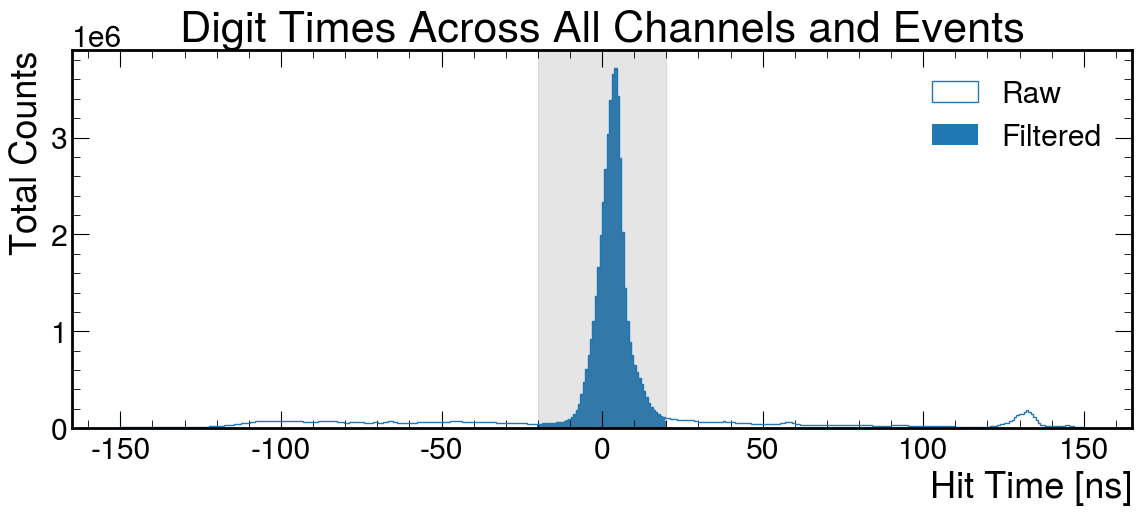

In [143]:

run.apply_hit_cleaning()
run.plot_timing_cut()


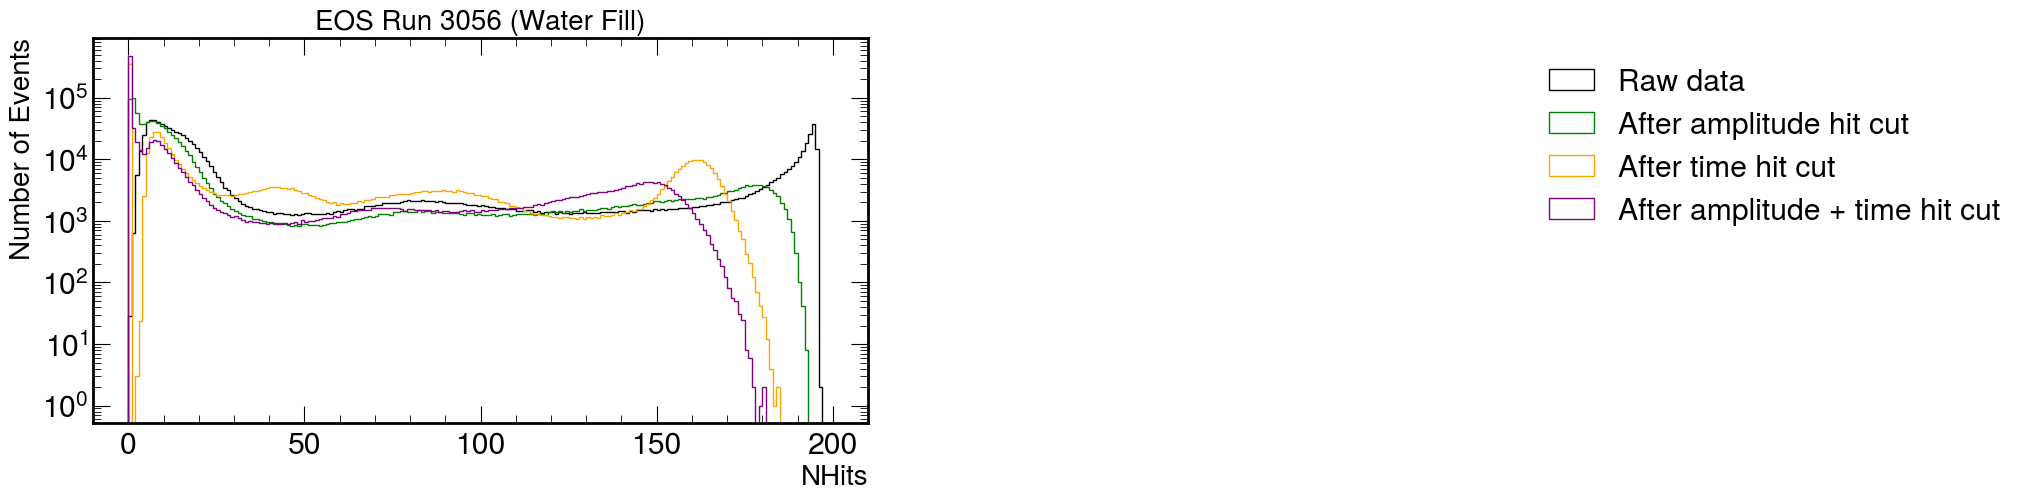

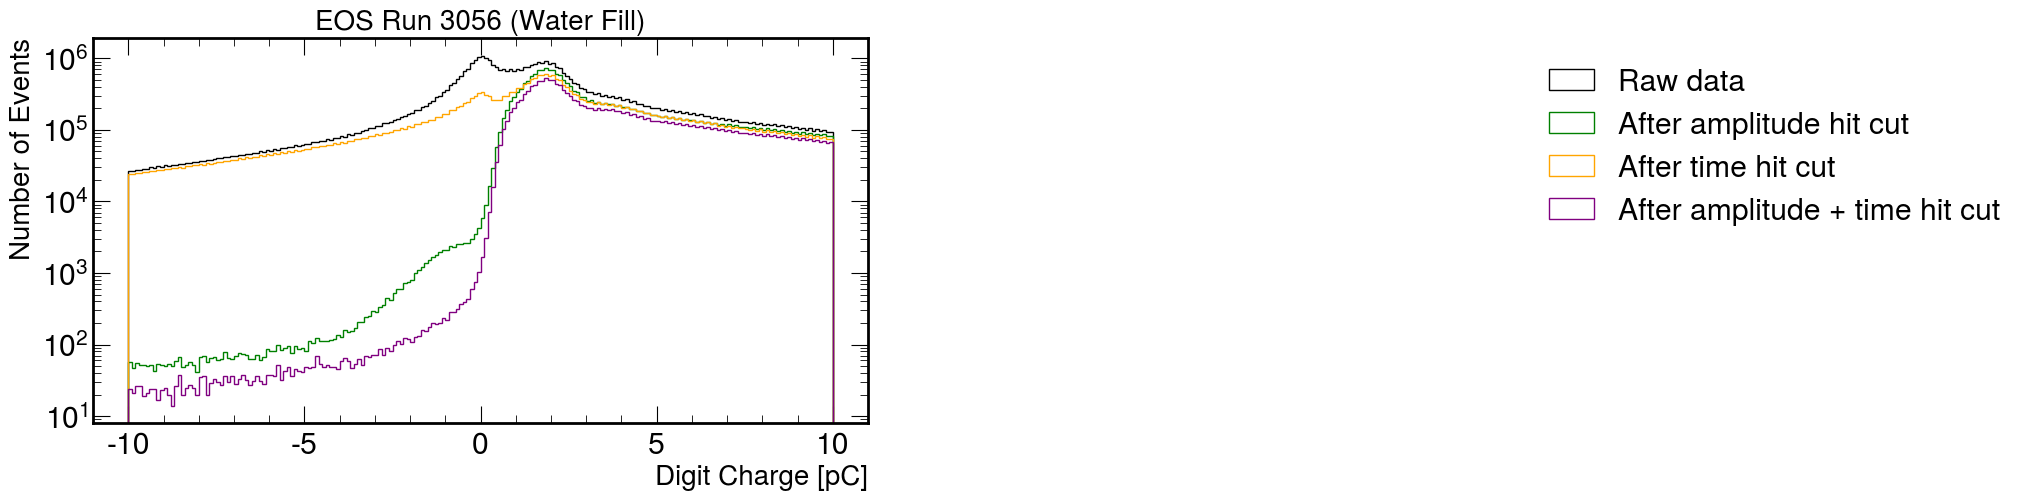

In [144]:

run.make_nhit_masks()

[ 5439744.  5441536. 17639936. ... 18484224. 34583808. 13201408.]
[False, False, False, False, False, ..., True, False, False, False, False]
[0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 129, ..., 148, 0, 136, 0, 0, 0, 92, 0, 0, 139, 1]


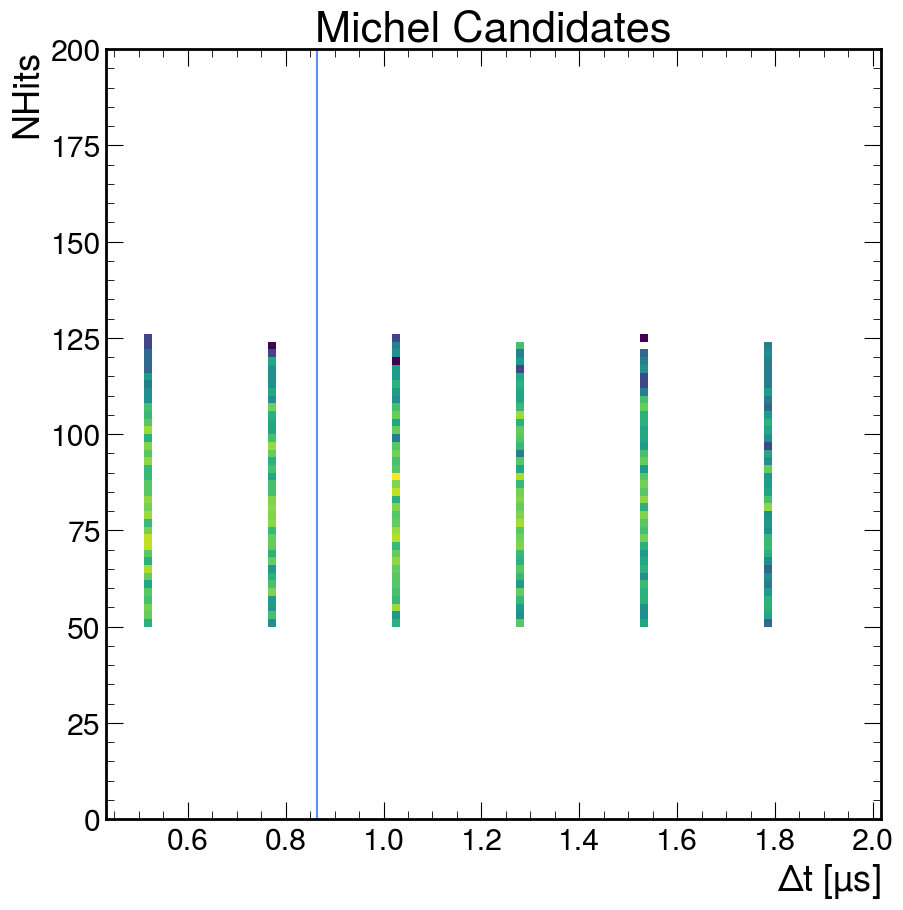

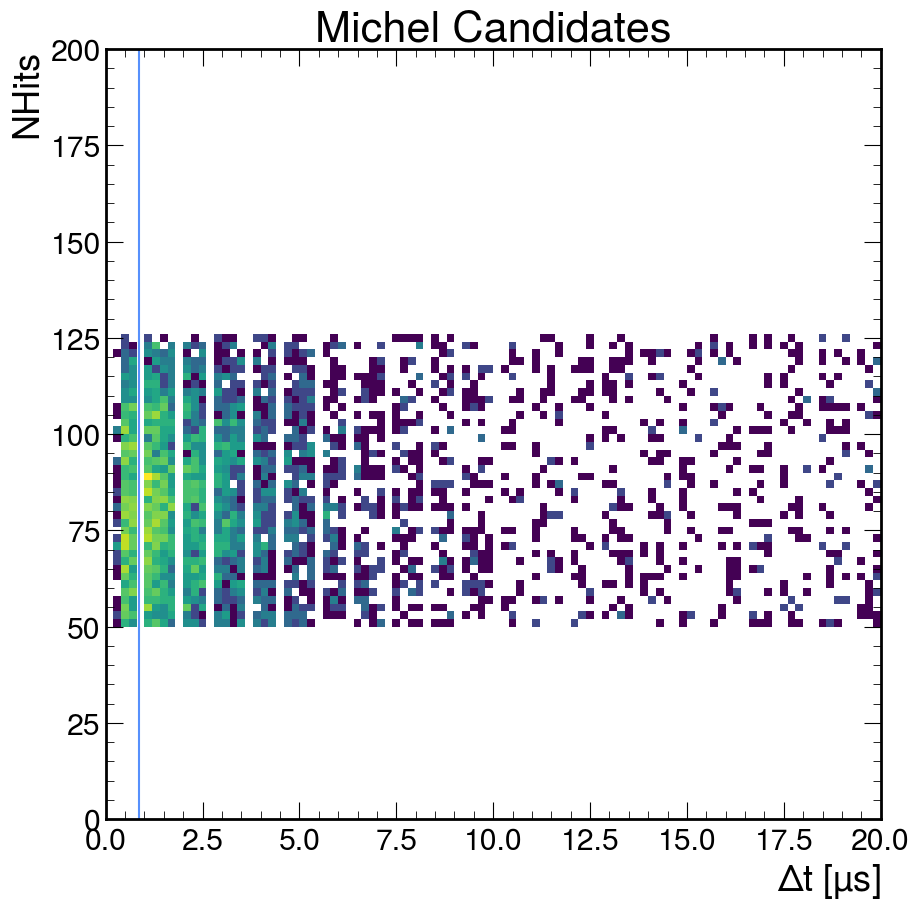

In [145]:

run.compute_delayed_times_relative_to_prompt_with_ts()
run.plot_nhit_dt()

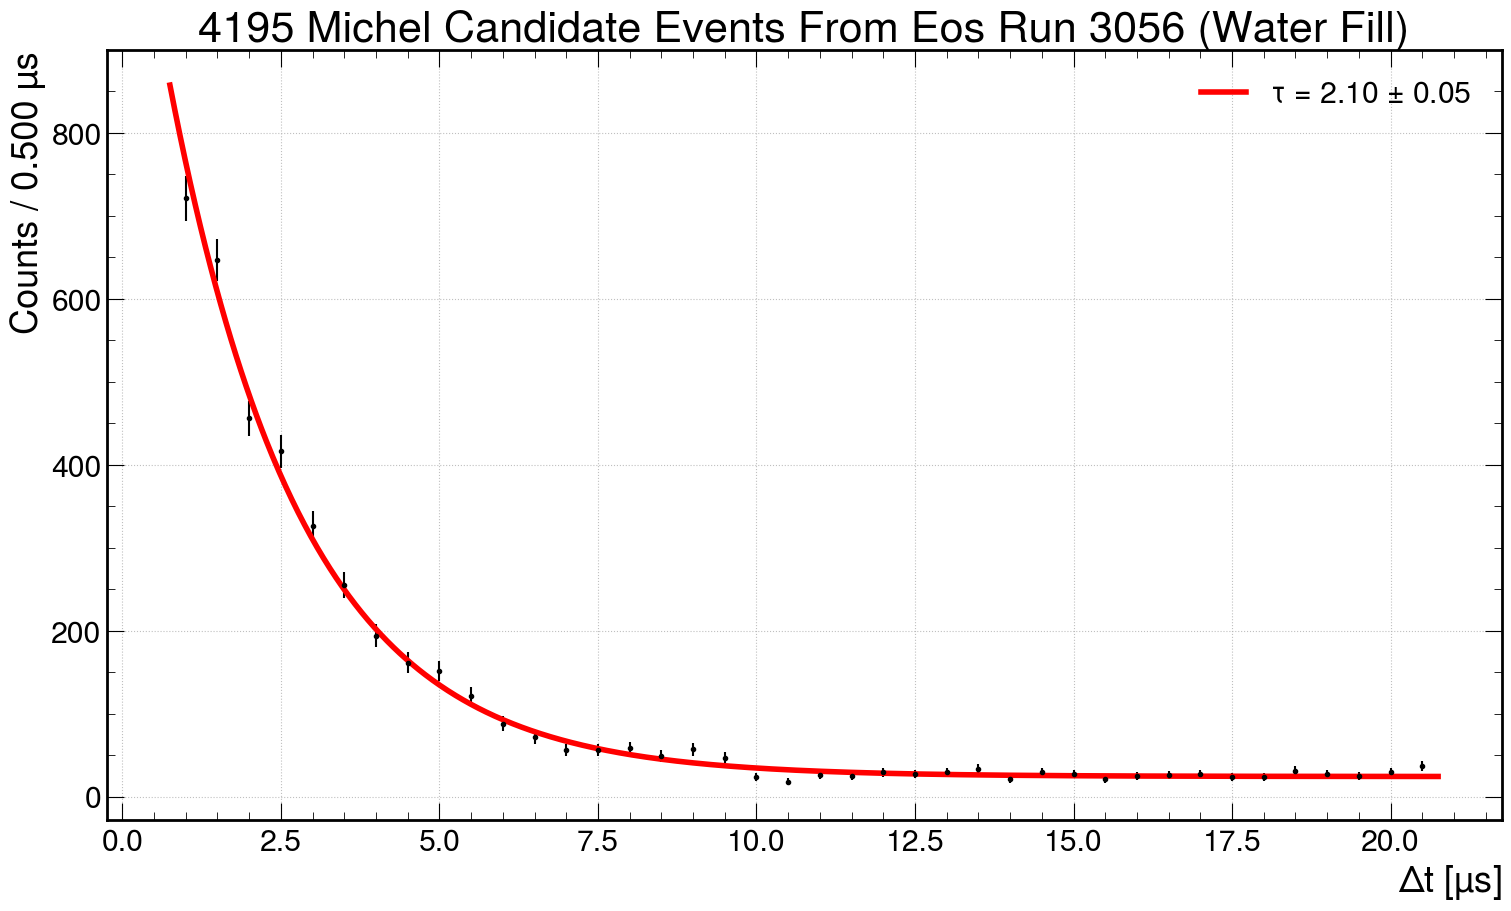

In [146]:
run.fit_muon_lifetime()

114656 [ 5439744.  5441536. 17639936. ... 18484224. 34583808. 13201408.]
1000000 [False, False, False, False, False, ..., True, False, False, False, False]
114656 [False False False ... False False False]
1000000 [False False False ... False False False]
4195


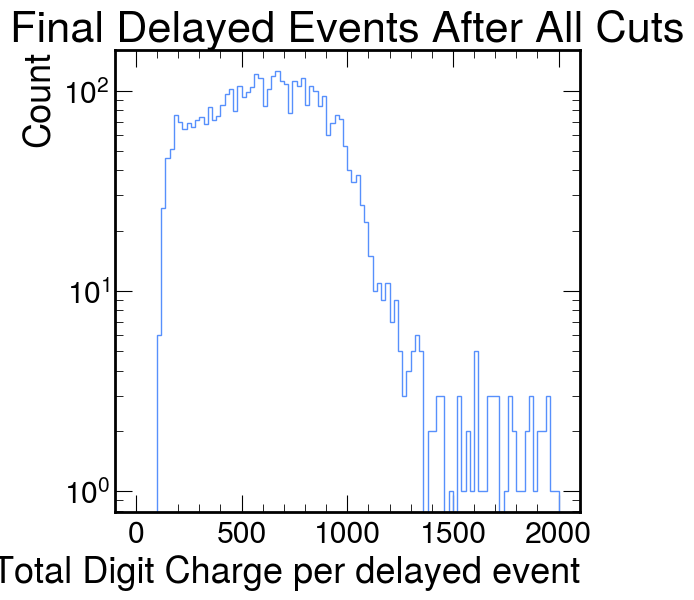

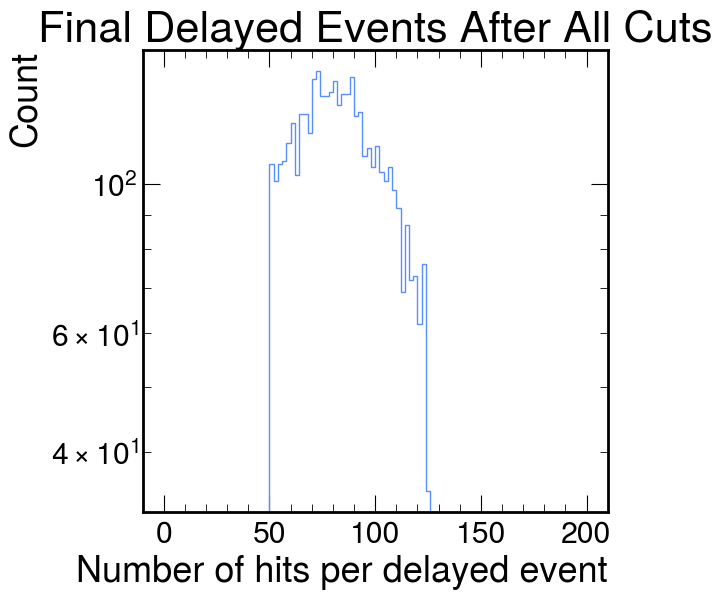

In [115]:
run.make_deliverables()
run.plot_final_nhit_charges()


<class 'range'>
3348


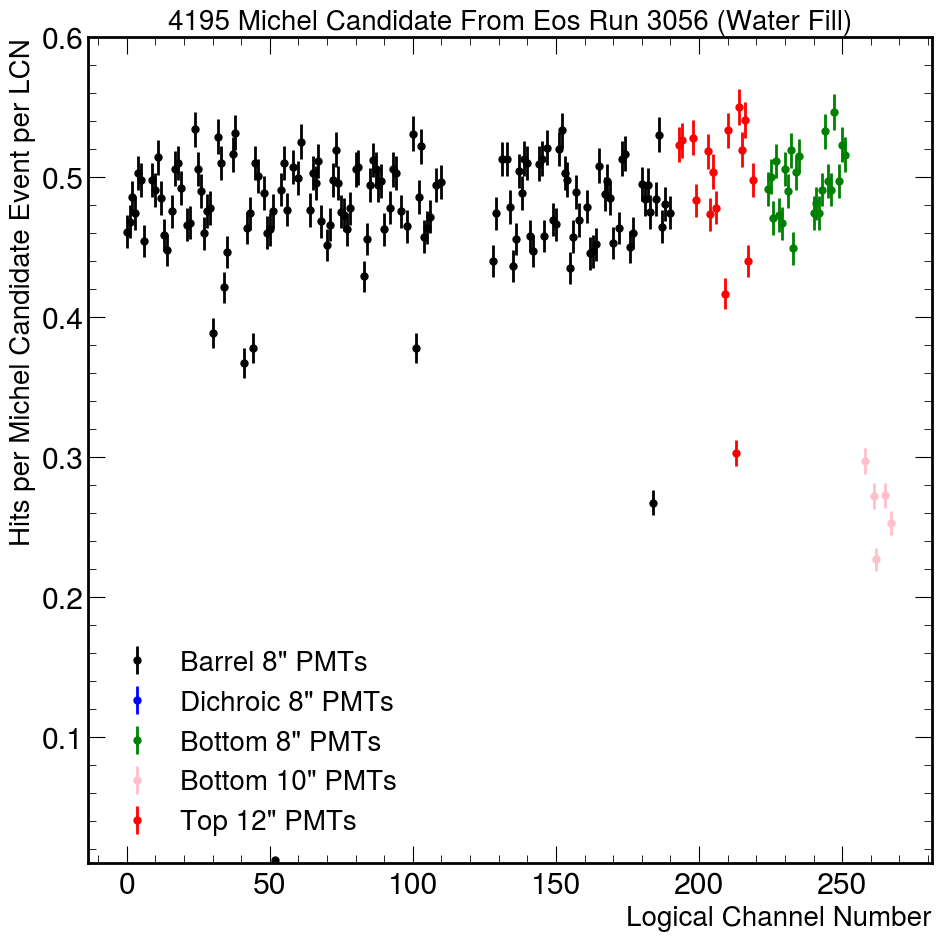

In [116]:

run.make_coincident_hits()
run.plot_coincident_data()

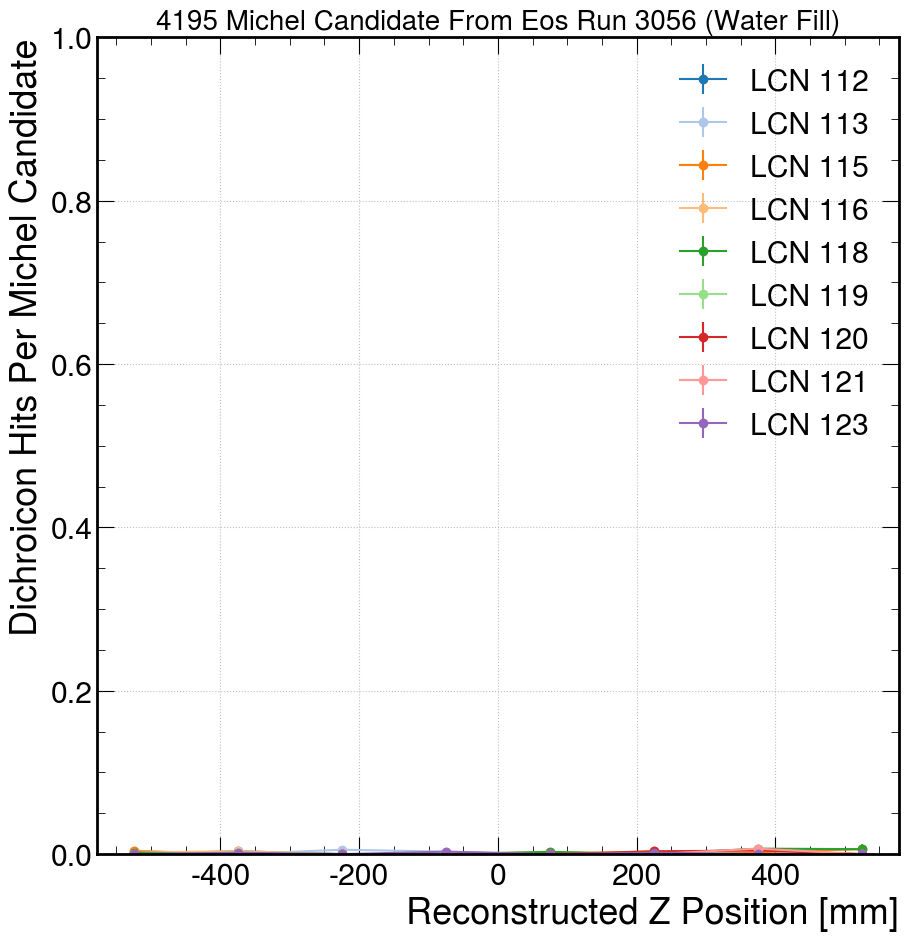

In [117]:
run.plot_dichroic_occupancy_vs_z(nbins=8)

In [118]:
print(run.dichroic_channels)




[112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [119]:

# import numpy as np
# import awkward as ak



# # dt_raw = compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_raw_mask, delayed_raw_mask)
# # dt_clean = compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_clean_mask, delayed_clean_mask)
# # # dt_time= compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_time_mask, delayed_time_mask)
# # # dt_amp_time = compute_delayed_times_relative_to_prompt_with_ts(timestamps, prompt_amp_time_mask, delayed_amp_time_mask)

# # #print(np.diff(np.unique(np.sort(dt_amp))))

# bins=20
# trange=(0.4,10.4)
# plt.figure(figsize=(6,6))
# plt.hist(dt_raw/1e3,bins=bins,range=trange,histtype='step',label='raw')
# plt.hist(dt_clean/1e3,bins=bins,range=trange,histtype='step',label='amp cut')
# #plt.hist(dt_time/1e3,bins=bins,range=trange,histtype='step',label='time cut')
# #plt.hist(dt_amp_time/1e3,bins=bins,range=trange,histtype='step',label='amp + time cut')
# plt.legend(loc='upper right')
# plt.xlabel('Delayed Trigger Time Since Last Prompt Trigger ($\mu$s)')
# #plt.semilogy()


In [120]:
print(run.pmt_is_online)
nonline = len(run.pmt_is_online[run.pmt_is_online==True])
noffline = len(run.pmt_is_online[run.pmt_is_online==False])
print(f"{nonline/(nonline+noffline):.3f}")

[ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True False False  True  True  True  True
 False False  True  True False  True  True False False  True  True  True
 False  True  True  True  True  True  True  True False False  True  True
  True  True  True  True  True  True  True  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True False False  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True False  True
 False  True  True False  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True False  True  True  True
 False  True False  True False  True  True  True  True  True  True  True
 False  True False  True  True  True  True False  T

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize



# def compare_decay_fits(datasets, labels, colors, bins=19, range=(0.8,20), tau_guess=2):
#     results = []
#     plt.figure(figsize=(8, 8))

#     for data, label, color in zip(datasets, labels, colors):
#         result = fit_decay(data, bins=bins, range=range, tau_guess=tau_guess)
#         results.append(result)

#         bin_centers = result['bin_centers']
#         counts = result['counts']
#         sigma = result['sigma']
#         A, tau, B = result['popt']
#         tau_err = result['perr'][1]

#         plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color=color, label=f"{label} (τ = {tau:.2f} ± {tau_err:.2f})")

#         t_fine = np.linspace(*range, 1000)
#         plt.plot(t_fine, decay_model(t_fine, *result['popt']), '-', color=color)

#     plt.xlabel("ΔT (µs)", fontsize=18)
#     plt.ylabel(f"Counts / {(range[1] - range[0]) / bins:.2f} µs", fontsize=18)
#     plt.title("Comparison of Decay Time Fits", fontsize=20)
#     plt.grid(True)
#     plt.legend(fontsize=12)
#     plt.tight_layout()
#     #plt.ylim(0,500)
#     # plt.xlim(range)
#     plt.semilogy()
#     plt.show()

#     # Print summary table
#     print("\nFit Summary:")
#     print(f"{'Label':<15} {'Tau (µs)':<15} {'Tau Err':<10} {'Chi²/dof':<10}")
#     for label, res in zip(labels, results):
#         tau = res['popt'][1]
#         tau_err = res['perr'][1]
#         chi2_red = res['chi2_red']
#         print(f"{label:<15} {tau:<15.3f} {tau_err:<10.3f} {chi2_red:<10.3f}")

#     return results


# # datasets = [dt_raw/1e3, dt_amp/1e3, dt_time/1e3, dt_amp_time/1e3]
# # labels = ['Raw', 'Amp Cut', 'Time Cut', 'Amp+Time Cut']
# # colors = ['black', 'blue', 'green', 'red']

# # results = compare_decay_fits(datasets, labels, colors)

# datasets = [dt_raw/1e3, dt_clean/1e3]
# labels = ['Raw', 'Amp Charge Cut']
# colors = ['black', 'blue']

# results = compare_decay_fits(datasets, labels, colors)

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize, approx_fprime
# from scipy.linalg import inv

# # === Model ===
# def decay_model(t, A, tau, B):
#     return A * np.exp(-t / tau) + B

# # === Negative Log-Likelihood ===
# def poisson_nll(p, t, n):
#     A, tau, B = p
#     mu = decay_model(t, A, tau, B)
#     mu = np.clip(mu, 1e-10, None)  # Avoid log(0)
#     return np.sum(mu - n * np.log(mu))

# # === Estimate Covariance Matrix ===
# def get_covariance_matrix(nll_func, best_params, args):
#     epsilon = np.sqrt(np.finfo(float).eps)
#     grad = lambda p: approx_fprime(p, nll_func, epsilon, *args)
#     n = len(best_params)
#     hessian = np.zeros((n, n))
#     for i in range(n):
#         def fi(xi):
#             p = best_params.copy()
#             p[i] = xi
#             return grad(p)[i]
#         hessian[i, i] = approx_fprime([best_params[i]], fi, epsilon)[0]
#     try:
#         cov = inv(hessian)
#         errors = np.sqrt(np.diag(cov))
#     except np.linalg.LinAlgError:
#         cov = None
#         errors = [np.nan] * len(best_params)
#     return cov, errors

# # === Main Fitting Function ===
# def fit_decay_poisson(data, bins, tau_guess=2):
#     counts, bin_edges = np.histogram(data, bins=bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

#     A_guess = np.max(counts)
#     B_guess = np.min(counts)
#     p0 = [A_guess, tau_guess, B_guess]

#     result = minimize(
#         poisson_nll,
#         p0,
#         args=(bin_centers, counts),
#         method='L-BFGS-B',
#         bounds=[(0, None), (1e-5, None), (0, None)]
#     )

#     popt = result.x
#     cov, perr = get_covariance_matrix(poisson_nll, popt, args=(bin_centers, counts))

#     mu = decay_model(bin_centers, *popt)
#     residuals = counts - mu
#     chi2 = np.sum((residuals ** 2) / mu)
#     dof = len(counts) - len(popt)
#     chi2_red = chi2 / dof if dof > 0 else float('inf')

#     return {
#         "bin_centers": bin_centers,
#         "counts": counts,
#         "bin_edges": bin_edges,
#         "popt": popt,
#         "perr": perr,
#         "chi2": chi2,
#         "chi2_red": chi2_red,
#         "success": result.success,
#         "message": result.message,
#     }

# # === Ex# Define the clock period
# clock_period = 0.160  # us

# # Start and stop times in us
# start_time = 2 * 0.432 + clock_period * 2  # e.g., 0.864 us
# nclock_cycles_to_plot = 300
# stop_time = start_time + (nclock_cycles_to_plot) * clock_period  # e.g., 0.912

# # Construct bin centers (i.e., where events should fall)
# bin_centers = np.arange(start_time, stop_time, clock_period)

# # Construct bin edges from centers ± 0.008 us
# half_width = clock_period / 2
# bin_edges = np.concatenate((
#     [bin_centers[0] - half_width],
#     bin_centers + half_width
# ))

# # Optionally verify:
# # print("Bin edges:", bin_edges)
# # print("Bin widths:", np.diff(bin_edges))
# # Fit
# result = fit_decay_poisson(dt_clean / 1e3, bins=bin_edges, tau_guess=2)

# # Plot
# t_fine = np.linspace(bin_edges[0], bin_edges[-1], 1000)
# plt.figure(figsize=(10, 6))
# sigma = np.sqrt(result["counts"])
# sigma[sigma == 0] = 1.0
# plt.errorbar(result["bin_centers"], result["counts"], yerr=sigma, fmt='o', label='Data (√N errors)')
# plt.plot(t_fine, decay_model(t_fine, *result["popt"]), label='Poisson Fit')
# plt.xlabel("Time [us]")
# plt.ylabel("Counts")
# plt.title("Poisson Likelihood Fit to Michel Decay")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Print result
# print("Fit parameters:")
# print(f"  A   = {result['popt'][0]:.3f} ± {result['perr'][0]:.3f}")
# print(f"  tau = {result['popt'][1]:.3f} ± {result['perr'][1]:.3f} us")
# print(f"  B   = {result['popt'][2]:.3f} ± {result['perr'][2]:.3f}")
# print(f"Reduced chi² = {result['chi2_red']:.2f}")



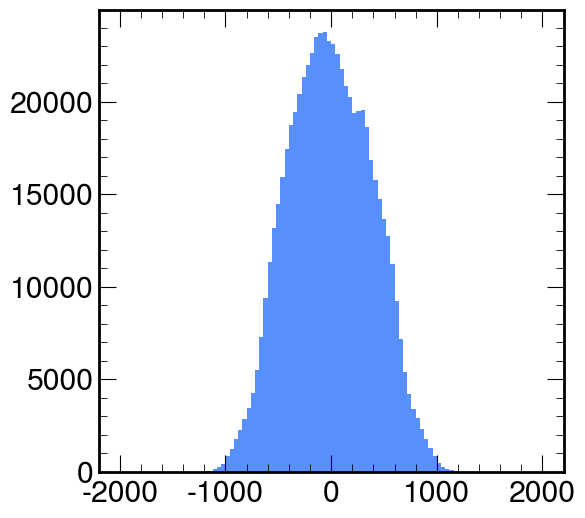

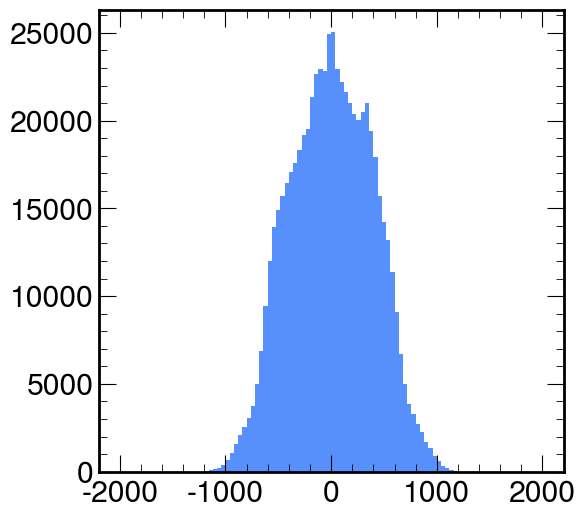

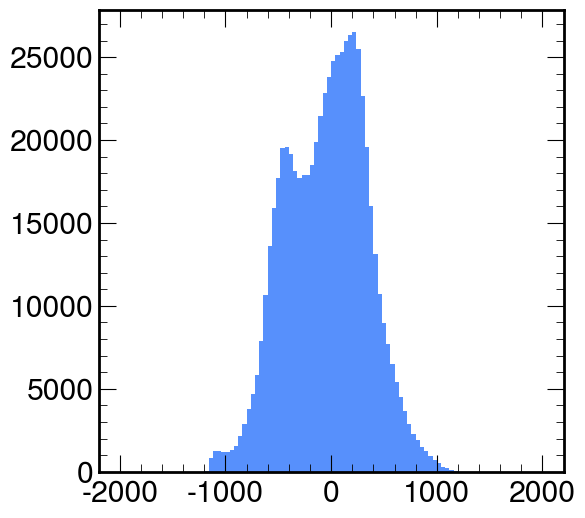

In [122]:

xfit = run.output_data['x_quadfitter']
yfit = run.output_data['y_quadfitter']
zfit = run.output_data['z_quadfitter']

def plt_fit(data):
    plt.figure(figsize=(6,6))
    plt.hist(data,bins=100,range=(-2000,2000))

plt_fit(xfit)
plt_fit(yfit)
plt_fit(zfit)

In [123]:



# # Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
# pmt_hit_counts = np.zeros(np.max(pmt_chs)+1, dtype=int)

# clean_ids = run.output_data['digitPMTID'][hit_amp_cut & hit_charge_cut & hit_time_cut]
# clean_ids = clean_ids[final_event_mask]
# nevents = len(clean_ids)
# print(nevents)

# # Flatten clean PMT IDs
# flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
# flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])

# # Use np.bincount to count hits per LCN (assuming pmt_ch == LCN)
# pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)


# # Normalize to hits per Michel candidate (optional)
# coinc_hit_counts = pmt_hit_counts / nevents 
# coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents


# # Plot
# plt.figure(figsize=(10, 10))
# #plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')
# plt.errorbar(barrel_channels, coinc_hit_counts[barrel_channels], yerr=coinc_hit_err[barrel_channels], fmt='o', color='black', label='Barrel Channels' )
# # Optional: highlight barrel and dichroic
# #plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
# plt.scatter(dichroic_channels, coinc_hit_counts[dichroic_channels], s=100, alpha=1, color='blue', label='Dichroic Channels')
# plt.scatter(behind_channels, coinc_hit_counts[behind_channels], s=100, alpha=1, color='pink', label='Bottom 10" PMTs')
# plt.scatter(bottom_channels, coinc_hit_counts[bottom_channels], s=100, alpha=1, color='green', label='Bottom 8" PMTs')
# plt.scatter(top_channels, coinc_hit_counts[top_channels], s=100, alpha=1, color='red', label='Top PMTs')

# plt.xlabel("Logical Channel Number")
# plt.ylabel("Hits per Michel Candidate")
# plt.legend(loc='upper center')
# plt.ylim(0.1,0.8)
# #plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
# plt.tight_layout()

In [124]:
# Fiducialize with x and y as well

In [125]:
# Get sim events!!!!!

In [126]:


# Event types by nhit 

# Time since last prompt event 

# Ringing

# Muon lifetime fit

# Channel delays 

# Hit time cut

# Position cut

# Normalization

# PMT plots


In [127]:

class SimRun:
    def __init__(self, file, pmt_is_online, nevents):
        self.file = Path(file) 
        self.nevents = nevents
        self.pmt_is_online = pmt_is_online

        # Root file variables 
        self.meta_data = None
        self.output_data = None

    
        # Hit cleaning masks
        # self.hit_amp_cut = None
        self.hit_id_cut = None
        self.hit_charge_cut = None
        self.hit_time_cut = None        

        # Hit cleaned data
        self.clean_charges = None
        self.clean_nhit = None

        # Event selection masks 
        self.prompt_raw_mask = None
        self.delayed_raw_mask = None 
        self.prompt_clean_mask = None 
        self.delayed_clean_mask = None 

        # Event selected data
        self.delayed_dt = None
        self.delayed_dt_mask = None 
        self.final_event_mask = None 
        self.final_charges = None 

        # Timing variables for plotting
        self.clock_period = 0.016  # us
        self.start_time = 3 * 0.432 + self.clock_period # 0  # e.g., 0.864 us
        self.nclock_cycles_to_plot = 500
        self.stop_time = self.start_time + (self.nclock_cycles_to_plot) * self.clock_period  # e.g., 0.912

        # PMT ids for plotting  
        self.barrel_ids = None 
        self.bottom_ids = None 
        self.dichroic_ids = None 
        self.top_ids = None 
        self.behind_ids = None 

    def print_nevents_in_file(self):
        f = up.open(self.file)
        print(f"There are {f['output'].num_entries} events in {self.file}")

    def load_meta_data(self):
        f = up.open(self.file)
        print(f"Meta Keys: {f['meta'].keys()}")
        start = time.time() 
        self.meta_data = f['meta'].arrays([
            'pmtType',
            'pmtId',
            'pmtChannel',
            'pmtIsOnline',
            'pmtCableOffset',
        ], entry_start=0, entry_stop=1, library='ak') 
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load meta data for {self.nevents} events")

    def load_event_data(self):
        f=up.open(self.file)
        print(f"Output Keys: {f['output'].keys()}")
        start = time.time()
        self.output_data = f['output'].arrays([
            'timestamp',
            'timeSinceLastTrigger_us',
            'digitPMTID',
            'digitTime',
            'digitCharge',
            'digitPeak',
            #'digitNegativePeak',
            'x_quadfitter',
            'y_quadfitter',
            'z_quadfitter',
            'time_quadfitter',
        ], entry_start=0, entry_stop=self.nevents, library='ak')
        stop = time.time()
        print(f"Took {stop-start:.2f} seconds to load output data for {self.nevents} events")

    # step 1
    def apply_hit_cleaning(self):
        # # Make hit amplitude ratio hit cut
        # digit_peak = self.output_data['digitPeak']
        # digit_neg_peak = self.output_data['digitNegativePeak']
        # ratio = digit_peak / digit_neg_peak
        # hit_amp_cut = ratio > 2

        # Check that the PMT is online

        # get boolean mask array from metadata
        #pmt_is_online = np.asarray(self.meta_data['pmtIsOnline'][0])  # shape (241,), bool
        pmt_is_online = np.asarray(self.pmt_is_online)  # shape (241,), bool

        # Step 2: get jagged array of PMT IDs
        ids = self.output_data['digitPMTID']  # shape [event][hit]

        # Step 3: apply element-wise mapping using NumPy boolean mask and `ak.Array`
        # We do this by converting to flat NumPy, indexing, and re-wrapping into the same structure
        flat_ids = ak.flatten(ids)                                # shape [total_hits]
        flat_mask = pmt_is_online[flat_ids]                        # shape [total_hits], bool
        hit_id_cut = ak.unflatten(flat_mask, ak.num(ids, axis=1))  # shape [event][hit]

        # Make positive charge hit cut 
        charges = self.output_data['digitCharge']
        hit_charge_cut = charges > 0

        # Make time cut
        times = self.output_data['digitTime']
        event_times = self.output_data['time_quadfitter']
        event_times = ak.broadcast_arrays(times, event_times)[1]
        times = times - event_times
        cut = [-10, 15]
        hit_time_cut = (times > cut[0]) & (times < cut[1])

        # Save important stuff
        # self.hit_amp_cut = hit_amp_cut
        self.hit_id_cut = hit_id_cut
        self.hit_charge_cut = hit_charge_cut
        self.hit_time_cut = hit_time_cut


    # step 2
    def make_nhit_masks(self):

        # Get raw data
        charges = self.output_data['digitCharge']

        # Apply hit cuts
        #clean_charges = ak.mask(charges, self.hit_amp_cut & self.hit_charge_cut & self.hit_time_cut)
        clean_charges = ak.mask(charges, self.hit_id_cut & self.hit_charge_cut & self.hit_time_cut)

        # Calculate NHits
        raw_nhit = ak.count(charges, axis=1)
        clean_nhit = ak.count(clean_charges, axis=1)

        # Make trigger type masks 
        prompt_min_nhit = 125
        delayed_min_nhit = 50

        prompt_raw_mask = raw_nhit >= prompt_min_nhit
        delayed_raw_mask = (raw_nhit >= delayed_min_nhit) & (raw_nhit < prompt_min_nhit)

        prompt_clean_mask = clean_nhit >= prompt_min_nhit
        delayed_clean_mask = (clean_nhit >= delayed_min_nhit) & (clean_nhit < prompt_min_nhit)

        raw_prompt = ak.count(ak.mask(raw_nhit, prompt_raw_mask), axis=None)
        raw_delayed = ak.count(ak.mask(clean_nhit, delayed_raw_mask), axis=None)

        clean_prompt = ak.count(ak.mask(clean_nhit, prompt_clean_mask), axis=None)
        clean_delayed = ak.count(ak.mask(clean_nhit, delayed_clean_mask), axis=None)

        # Plot NHits
        max_nhit=200
        fontsize=20
        plt.figure(figsize=(10,5))
        plt.hist(raw_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='black',linestyle='--',label=f"Before: {raw_prompt} prompt {raw_delayed} delayed");
        plt.hist(clean_nhit,bins=max_nhit,range=(0,max_nhit),histtype='step',color='black',label=f"After: {clean_prompt} prompt {clean_delayed} delayed");
        plt.title('EOS Water Fill Run 3046',fontsize=fontsize)
        plt.xlabel('NHits',fontsize=fontsize)
        plt.ylabel('Number of Events',fontsize=fontsize)
        plt.axvspan(125,200,color='blue',alpha=0.3,label='Stopping Muon Candidates')
        plt.axvspan(50,125,color='red',alpha=0.3,label='Michel Electron Candidates')
        plt.semilogy()
        plt.legend(ncol=1,loc='upper center',bbox_to_anchor=(1.25,1),fontsize=15)

        # Save important stuff
        self.prompt_raw_mask = prompt_raw_mask 
        self.delayed_raw_mask = delayed_clean_mask

        self.clean_charges = clean_charges
        self.clean_nhit = clean_nhit
        self.prompt_clean_mask = prompt_clean_mask 
        self.delayed_clean_mask = delayed_clean_mask

    # step 3 
    def make_deliverables(self):

        dt_clean = self.delayed_dt
        delayed_clean_mask = self.delayed_clean_mask
        clean_charges = self.clean_charges

        # 8. Apply delay time cut (dt < 3 µs) to delayed events
        
        # 9. Select only delayed events that passed the time cut
        # delayed_amp_time_mask is [all events] — we now filter that with time_mask
        final_event_mask = ak.Array(delayed_clean_mask)  # shape: [events]
        # Get indices of delayed events
        delayed_indices = ak.where(delayed_clean_mask)[0]  # np.array of indices
        
        # Now build final event-level mask
        final_event_mask = np.zeros(len(delayed_clean_mask), dtype=bool)
        final_event_mask[delayed_indices] = True  # shape: [event]
        
        # 10. Final cleaned arrays (hits within selected delayed events)
        digit_charge_final = clean_charges[final_event_mask]


        # Save important stuff
        self.final_event_mask = final_event_mask
        self.final_charges = digit_charge_final


    def make_coincident_hits(self):

        final_event_mask = self.final_event_mask

        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0]

        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
        id2board = dict(zip(ch2id.values(), [ch//16 for ch in ch2id.keys()]))

        digit_ids = self.output_data['digitPMTID']

        print(range)
        

        # Define PMT channels
        barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
        barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]

        special_channels = np.arange(0, 36, 1)

        top_boards =  [12, 13]
        top_channels = [16 * board + i for board in top_boards for i in range(16)]

        dichroic_boards = [7]
        dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

        bottom_boards = [14, 15]
        bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

        behind_boards = [16]
        behind_channels = [16 * board + i for board in behind_boards for i in range(13)]


        # Convert channel lists to ID lists
        barrel_ids = [ch2id[ch] for ch in barrel_channels if ch in ch2id]
        bottom_ids = [ch2id[ch] for ch in bottom_channels if ch in ch2id]
        dichroic_ids = [ch2id[ch] for ch in dichroic_channels if ch in ch2id]
        special_ids = [ch2id[ch] for ch in special_channels if ch in ch2id]
        top_ids = [ch2id[ch] for ch in top_channels if ch in ch2id]
        behind_ids = [ch2id[ch] for ch in behind_channels if ch in ch2id]

         # Should really do a fiducial cut for x,y,z
        pos_min = -600
        pos_max = 600
        
        x_fit = self.output_data['x_quadfitter']
        x_mask = (x_fit > pos_min) & (x_fit < pos_max)
        
        y_fit = self.output_data['y_quadfitter']
        y_mask = (y_fit > pos_min) & (y_fit < pos_max)

        z_fit = self.output_data['z_quadfitter']
        z_mask = (z_fit > pos_min) & (z_fit < pos_max)

        pos_final_event_mask = final_event_mask & x_mask & y_mask & z_mask
        
        
        # Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
        pmt_hit_counts = np.zeros(np.max(pmt_chs)+1, dtype=int)
        
        clean_ids = self.output_data['digitPMTID'][self.hit_id_cut & self.hit_charge_cut & self.hit_time_cut]
        clean_ids = clean_ids[pos_final_event_mask]
        nevents = len(clean_ids)
        print(nevents)
        
        # Flatten clean PMT IDs
        
        flat_clean_ids = ak.to_numpy(ak.flatten(clean_ids))
        flat_clean_lcns = np.array([id2ch[id] for id in flat_clean_ids])
        
        # Use np.bincount to count hits per LCN (assuming pmt_ch == LCN)
        pmt_hit_counts = np.bincount(flat_clean_lcns, minlength=np.max(pmt_chs)+1)
        
        
        # Normalize to hits per Michel candidate (optional)
        coinc_hit_counts = pmt_hit_counts / nevents 
        coinc_hit_err = np.sqrt(pmt_hit_counts) / nevents

        # Save important stuff
        self.barrel_channels = barrel_channels
        self.bottom_channels = bottom_channels
        self.dichroic_channels = dichroic_channels
        self.top_channels = top_channels
        self.behind_channels = behind_channels

        self.coinc_hit_counts = coinc_hit_counts
        self.coinc_hit_err = coinc_hit_err
        

    def plot_coincident_data(self):


        ms = 5
        lw = 2
        # Plot
        plt.figure(figsize=(10, 10))
        #plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')
        plt.errorbar(self.barrel_channels, self.coinc_hit_counts[self.barrel_channels], yerr=self.coinc_hit_err[self.barrel_channels], fmt='o', ms=ms, lw=lw, color='black', label='Barrel 8" PMTs' )
        # Optional: highlight barrel and dichroic
        #plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
        plt.errorbar(self.dichroic_channels, self.coinc_hit_counts[self.dichroic_channels], yerr=self.coinc_hit_err[self.dichroic_channels], fmt='o', ms=ms, lw=lw, color='blue', label='Dichroic 8" PMTs')
        plt.errorbar(self.bottom_channels, self.coinc_hit_counts[self.bottom_channels], yerr=self.coinc_hit_err[self.bottom_channels], fmt='o', ms=ms, lw=lw, color='green', label='Bottom 8" PMTs')
        plt.errorbar(self.behind_channels, self.coinc_hit_counts[self.behind_channels], yerr=self.coinc_hit_err[self.behind_channels], fmt='o', ms=ms, lw=lw, color='pink', label='Bottom 10" PMTs')
        plt.errorbar(self.top_channels, self.coinc_hit_counts[self.top_channels], yerr=self.coinc_hit_err[self.top_channels], fmt='o', ms=ms, lw=lw, color='red', label='Top 12" PMTs')

        fontsize=20
        plt.xlabel("Logical Channel Number",fontsize=fontsize)
        plt.ylabel("Hits per Michel Candidate",fontsize=fontsize)
        plt.title(f"{len(self.final_charges)} Michel Events Simulated in Eos (Water Fill)",fontsize=fontsize)
        plt.legend(loc='lower left',fontsize=fontsize)#,bbox_to_anchor=(-1.1,1))
        plt.ylim(0.01,0.6)
        #plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
        plt.tight_layout()
        
    def plot_dichroic_occupancy_vs_z(self, nbins=20):
        import matplotlib.pyplot as plt
        import numpy as np
        import awkward as ak       
    
        # Channel ↔ PMT ID maps
        pmt_ids = self.meta_data['pmtId'][0]
        pmt_chs = self.meta_data['pmtChannel'][0]
        id2ch = dict(zip(pmt_ids, pmt_chs))
        ch2id = dict(zip(pmt_chs, pmt_ids))
    
        # Fiducial cuts
        x_fit = self.output_data['x_quadfitter']
        y_fit = self.output_data['y_quadfitter']
        z_fit_all = self.output_data['z_quadfitter']
        fiducial_mask = (
            self.final_event_mask &
            (x_fit > -600) & (x_fit < 600) &
            (y_fit > -600) & (y_fit < 600) &
            (z_fit_all > -600) & (z_fit_all < 600)
        )
    
        # Get z positions of selected events
        z_fit = ak.to_numpy(z_fit_all[fiducial_mask])
    
        # Hit-level mask
        hit_mask = self.hit_id_cut & self.hit_charge_cut & self.hit_time_cut
        digit_ids = self.output_data['digitPMTID'][hit_mask]
        digit_ids = digit_ids[fiducial_mask]  # Apply event-level mask
    
        # Bin setup
        bins = np.linspace(-600, 600, nbins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
    
        # Get dichroic PMT IDs
        dichroic_ids = {ch2id[ch] for ch in self.dichroic_channels if ch in ch2id}
        lcn_list = sorted([id2ch[pid] for pid in dichroic_ids])  # Ensure these are real
    
        # Initialize hit and event counters
        z_bin_hits = {lcn: np.zeros(nbins) for lcn in lcn_list}
        z_bin_counts = np.zeros(nbins)
    
        # Fill bins
        for z, event_hits in zip(z_fit, digit_ids):
            bin_idx = np.searchsorted(bins, z, side='right') - 1
            if 0 <= bin_idx < nbins:
                z_bin_counts[bin_idx] += 1
                for pid in event_hits:
                    if pid in dichroic_ids:
                        lcn = id2ch[pid]
                        z_bin_hits[lcn][bin_idx] += 1
    
        # Filter LCNs that have at least one hit
        active_lcns = [lcn for lcn in lcn_list if np.sum(z_bin_hits[lcn]) > 0]
    
        # Color map setup with distinct colors
        cmap = plt.get_cmap("tab20")
        colors = [cmap(i % 20) for i in range(len(active_lcns))]
    
        # Plot
        plt.figure(figsize=(10, 10))
        for i, lcn in enumerate(active_lcns):
            with np.errstate(divide='ignore', invalid='ignore'):
                avg = z_bin_hits[lcn] / z_bin_counts
                err = np.sqrt(z_bin_hits[lcn]) / z_bin_counts
    
            plt.errorbar(bin_centers, avg, yerr=err, label=f"LCN {lcn}",
                         marker='o', linestyle='-', color=colors[i])
    
        plt.xlabel("Reconstructed Z Position [mm]")
        plt.ylabel("Dichroicon Hits Per Michel Event")
        plt.title(f"{len(self.final_charges)} Michel Events Simulated in EOS (Water Fill)",fontsize=20)
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.ylim(0,1)
        plt.show()

    # Optional Plotting
    def plot_final_nhit_charges(self):
 
        digit_charge_final = self.final_charges
 
 
        print(len(digit_charge_final))
        
        # 11. Plot number of valid hits per selected delayed event
        plt.figure(figsize=(6,6))
        plt.hist(ak.sum(digit_charge_final,axis=1),bins=100,range=(0,2000),histtype='step')
        plt.xlabel("Total Digit Charge per delayed event")
        plt.ylabel("Count")
        plt.title("Final Delayed Events After All Cuts")
        plt.yscale('log')
        plt.show()
        
        # 11. Plot number of valid hits per selected delayed event
        plt.figure(figsize=(6,6))
        plt.hist(ak.count(digit_charge_final,axis=1),bins=100,range=(0,200),histtype='step')
        plt.xlabel("Number of hits per delayed event")
        plt.ylabel("Count")
        plt.title("Final Delayed Events After All Cuts")
        plt.yscale('log')
        plt.show()
 
    def plot_timing_cut(self):

        # Make time cut
        times = self.output_data['digitTime']
        event_times = self.output_data['time_quadfitter']
        event_times = ak.broadcast_arrays(times, event_times)[1]
        times = times - event_times
        cut = [-10, 15]
        hit_time_cut = (times > cut[0]) & (times < cut[1])
        # Apply time cut
        cut_times = ak.mask(times, hit_time_cut)

        # Plot
        plt.figure(figsize=(12, 6))
        plt.hist(ak.flatten(times), bins=400, range=(-200, 200), histtype='step',label='Raw', color='tab:blue')
        plt.hist(ak.flatten(cut_times), bins=400, range=(-200, 200),label='Filtered', color='tab:blue')
        plt.axvspan(cut[0], cut[1], color='grey', alpha=0.2)
        plt.xlabel('Hit Time [ns]')
        plt.ylabel('Total Counts')
        plt.title('Digit Times Across All Channels and Events')
        plt.legend()
        plt.tight_layout()
        #plt.semilogy()
        #plt.ylim(1e5.1e7)
        plt.show()



In [128]:
#sim_michel = "/nfs/disk1/users/bharris/eos/new_sim/michel/eos_sim1246_100000.ntuple.root"
sim_michel = "/nfs/disk1/users/bharris/eos/sim/michels/1-50.ntuple.root"

sim = SimRun(sim_michel,run.pmt_is_online,nevents=50000)
sim.print_nevents_in_file()
sim.load_meta_data()
sim.load_event_data()


There are 50007 events in /nfs/disk1/users/bharris/eos/sim/michels/1-50.ntuple.root
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Took 0.00 seconds to load meta data for 50000 events
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'event_cleaning_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcnhits', 

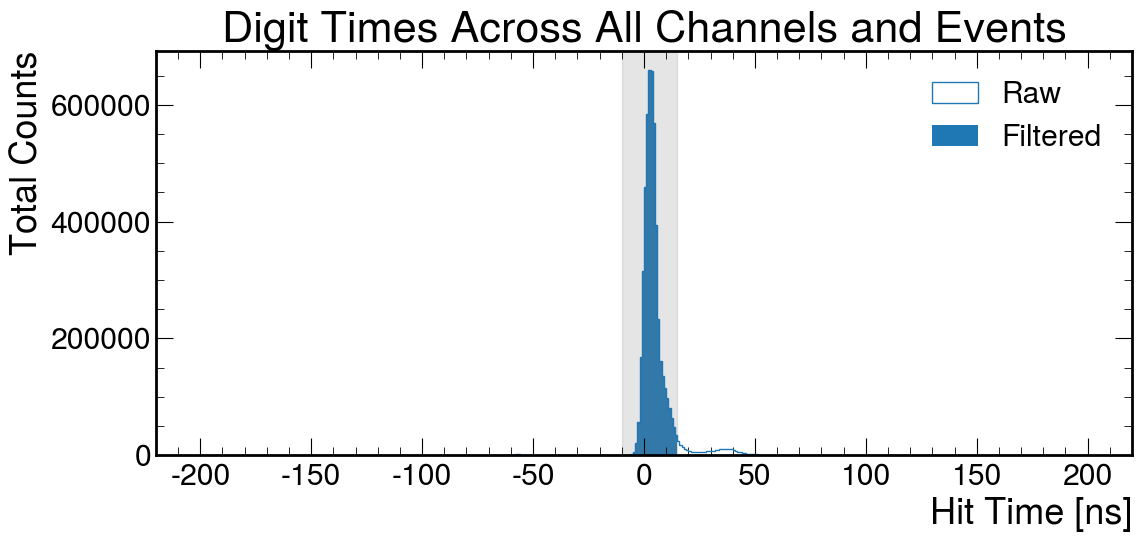

In [129]:
sim.apply_hit_cleaning()
sim.plot_timing_cut()

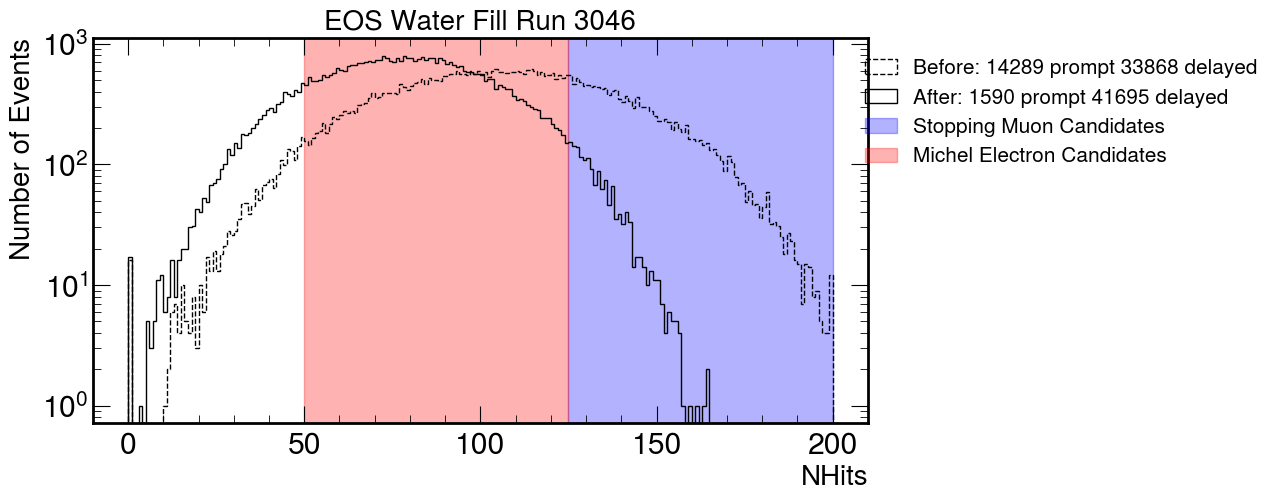

In [130]:
sim.make_nhit_masks() 

41695


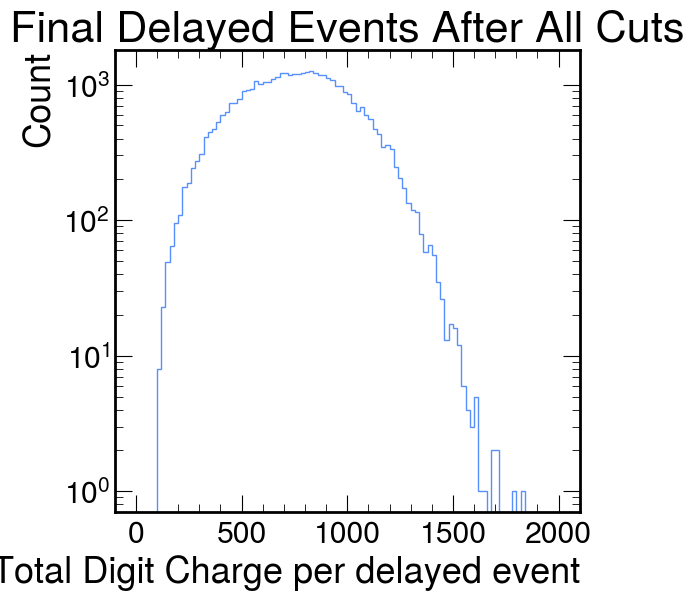

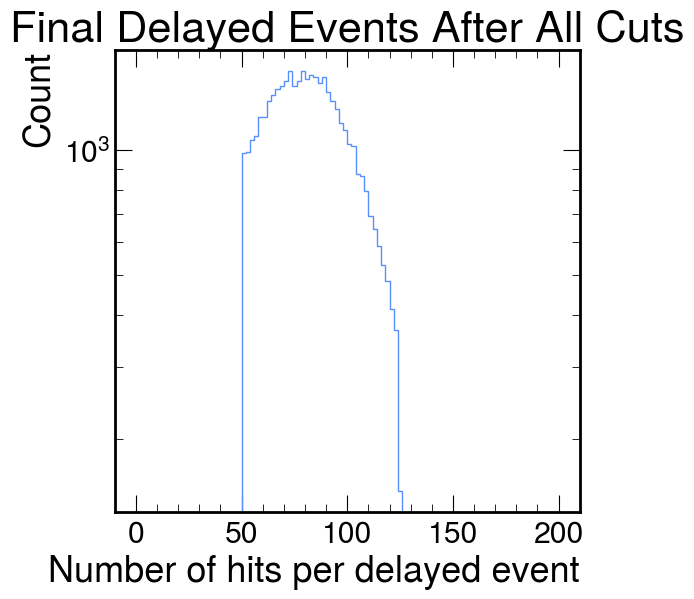

In [131]:
sim.make_deliverables()
sim.plot_final_nhit_charges()

<class 'range'>
24742


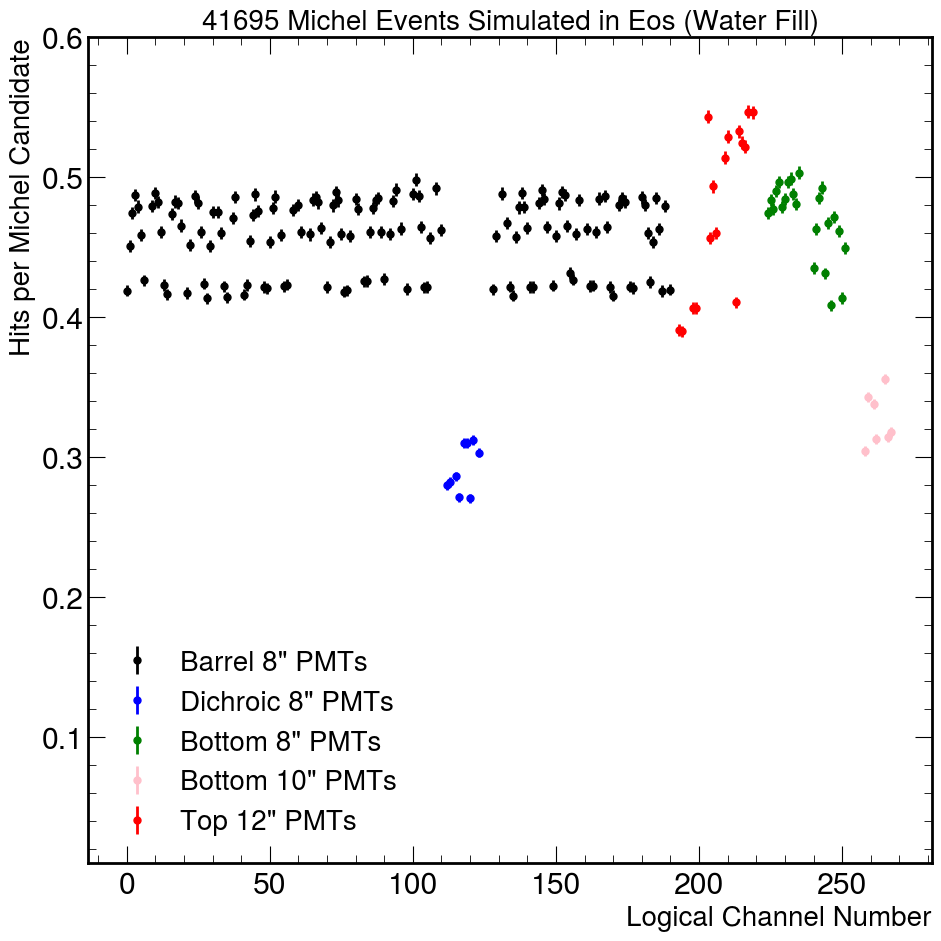

In [132]:
sim.make_coincident_hits()
sim.plot_coincident_data()

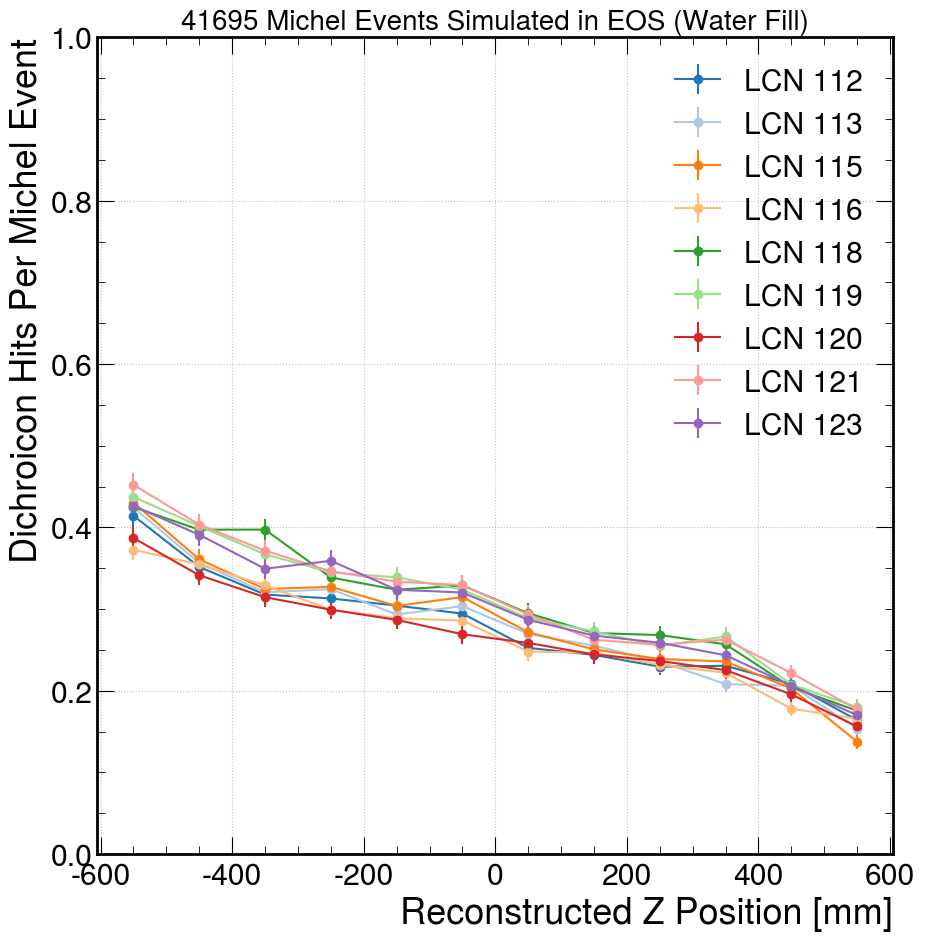

In [133]:
sim.plot_dichroic_occupancy_vs_z(nbins=12)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    2.,
          15.,   76.,  251.,  447.,  603.,  673.,  810.,  992., 1006.,
        1125., 1152., 1277., 1296., 1360., 1465., 1497., 1510., 1474.,
        1529., 1590., 1645., 1565., 1607., 1622., 1655., 1543., 1631.,
        1592., 1526., 1515., 1425., 1432., 1390., 1277., 1244., 1182.,
        1145.,  981.,  945.,  837.,  698.,  616.,  442.,  233.,   84.,
          15.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.]),
 array([-2000., -1960., -1920., -1880., -1840., -1800., -1760., -1720.,
        -1680., -1640., -1600., -1560., -1520., -1480., -1440., -1400.,
        -1360., -1320., -1280., -1240., -1200., -1160., -1

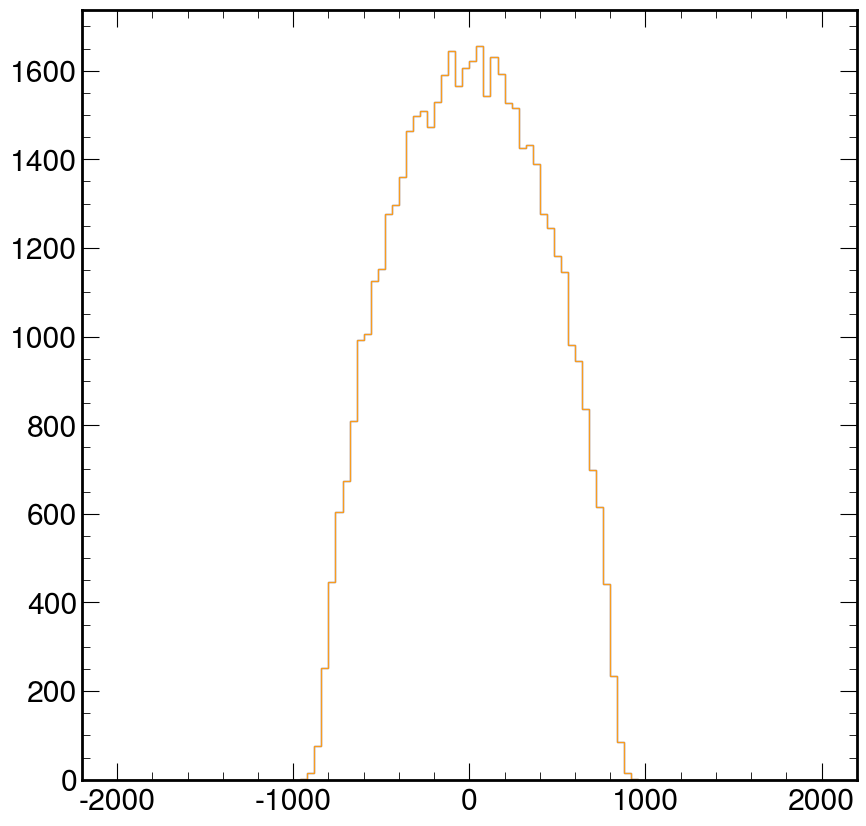

In [134]:


plt.hist(sim.output_data['x_quadfitter'],bins=100,range=(-2000,2000),histtype='step')
plt.hist(sim.output_data['x_quadfitter'],bins=100,range=(-2000,2000),histtype='step')

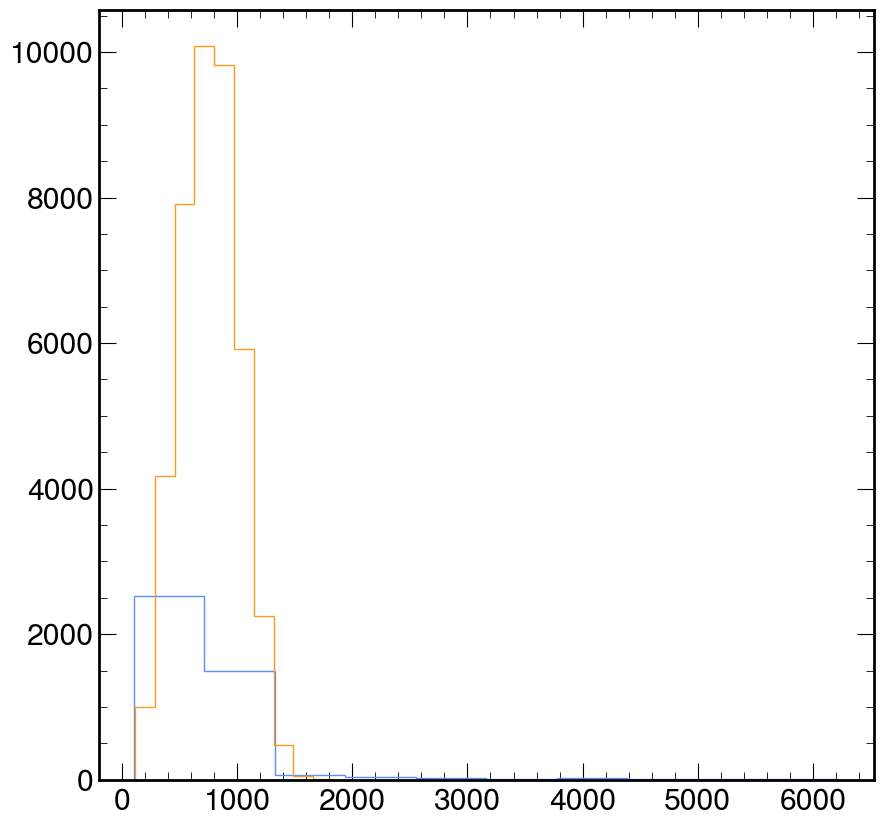

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


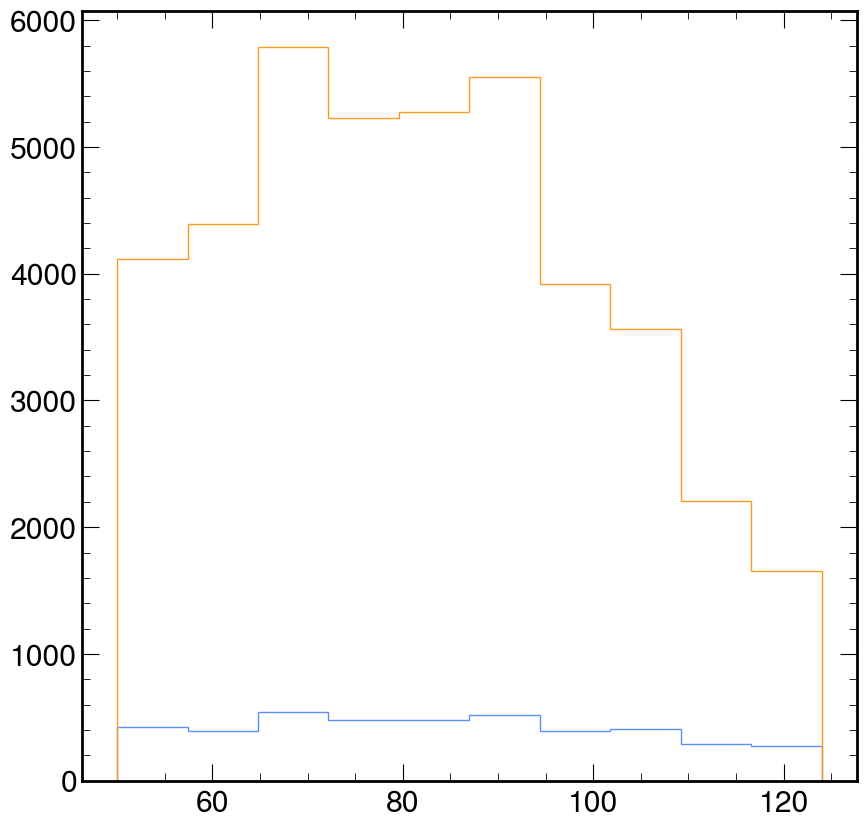

In [135]:
run_charges = run.final_charges
sim_charges = sim.final_charges

plt.hist(ak.sum(run_charges,axis=1),histtype='step')
plt.hist(ak.sum(sim_charges,axis=1),histtype='step')
plt.show()

plt.hist(ak.count(run_charges,axis=1),histtype='step')
plt.hist(ak.count(sim_charges,axis=1),histtype='step')
plt.legend()
plt.show()

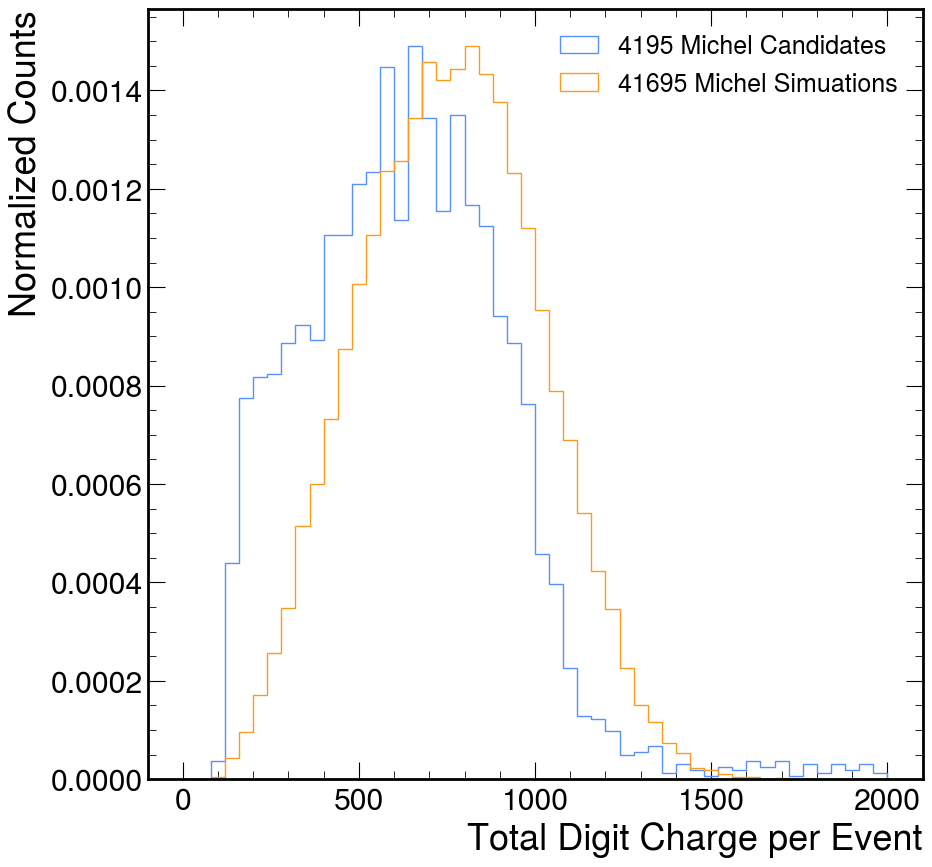

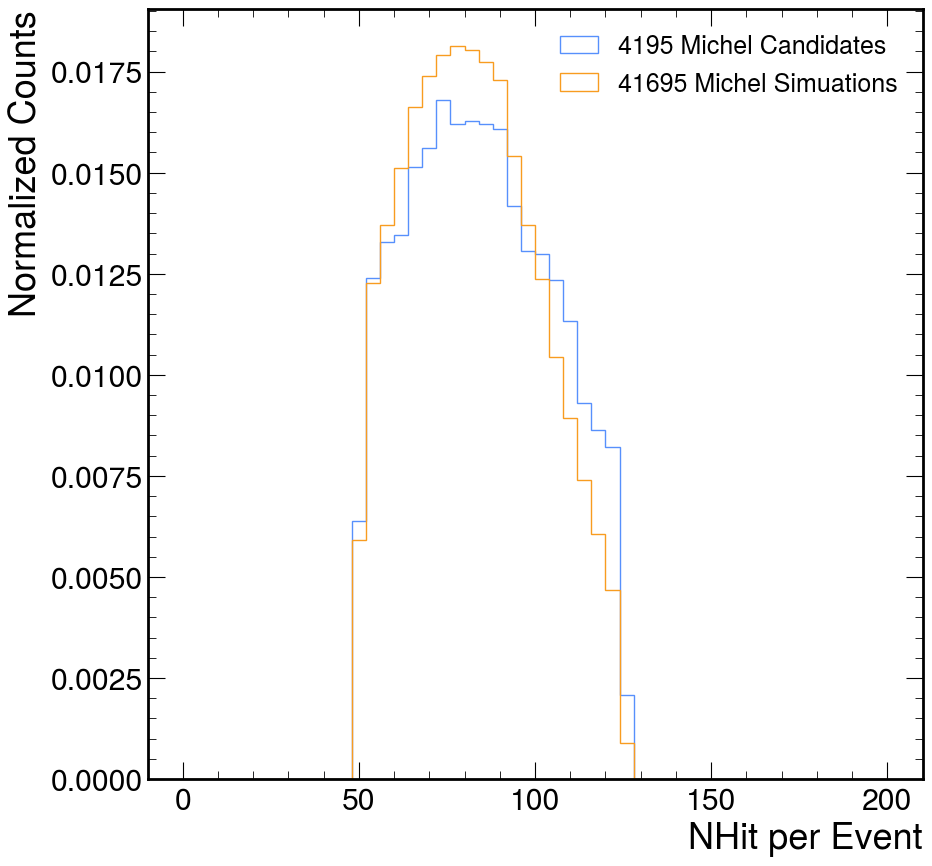

In [136]:
nbins=50
tc_range=(0,2000)
nhit_range=(0,200)

plt.hist(ak.sum(run_charges, axis=1), histtype='step', bins=nbins, range=tc_range, density=True, label=f"{len(run_charges)} Michel Candidates")
plt.hist(ak.sum(sim_charges, axis=1), histtype='step', bins=nbins, range=tc_range, density=True, label=f"{len(sim_charges)} Michel Simuations")
plt.xlabel('Total Digit Charge per Event')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right',fontsize=18)
plt.show()

plt.hist(ak.count(run_charges, axis=1), histtype='step', bins=nbins, range=nhit_range, density=True, label=f"{len(run_charges)} Michel Candidates")
plt.hist(ak.count(sim_charges, axis=1), histtype='step', bins=nbins, range=nhit_range, density=True, label=f"{len(sim_charges)} Michel Simuations")
plt.xlabel('NHit per Event')
plt.ylabel('Normalized Counts')
plt.legend(loc='upper right',fontsize=18)
plt.show()


/tmp/ipykernel_1614945/2350449237.py:8: RuntimeWarning: invalid value encountered in divide
  diff = (data_hits - sim_hits) / sim_hits * 100  # % difference
/tmp/ipykernel_1614945/2350449237.py:9: RuntimeWarning: invalid value encountered in divide
  diff_err = np.sqrt(data_err**2 + sim_err**2) / sim_hits * 100  # propagate as percent


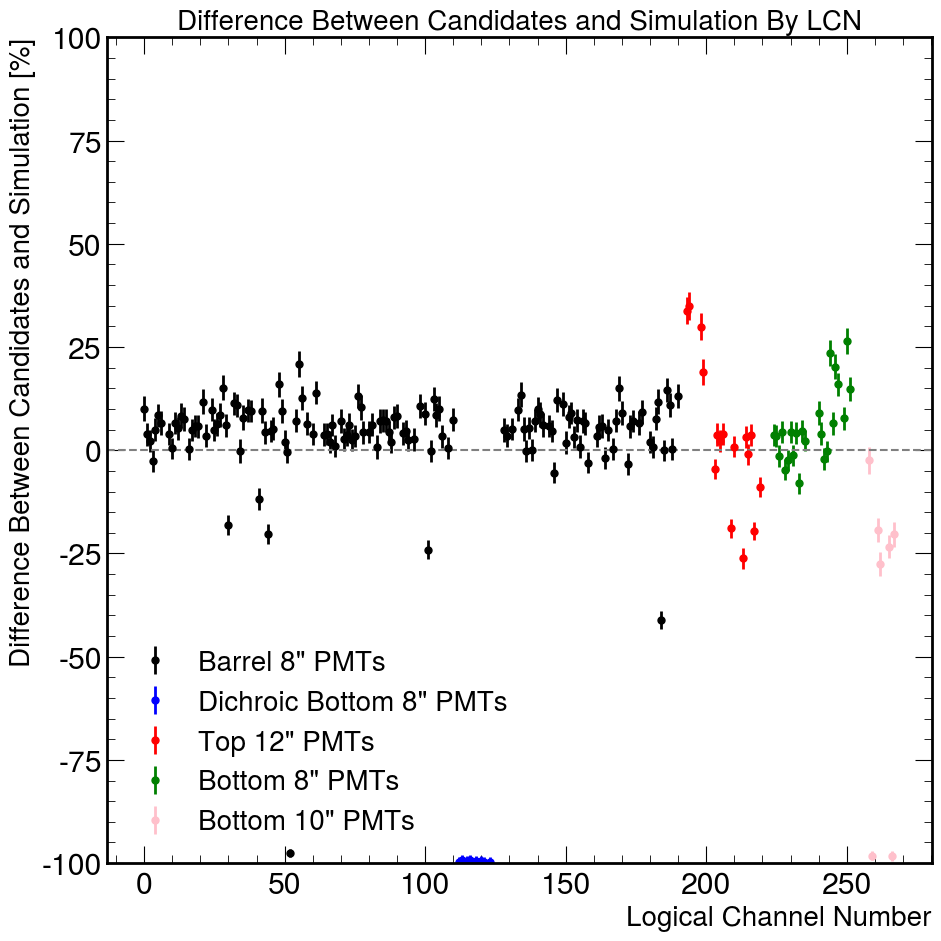

In [137]:
# For each LCN
data_hits = run.coinc_hit_counts         # shape [n_channels]
data_err  = run.coinc_hit_err

sim_hits = sim.coinc_hit_counts
sim_err  = sim.coinc_hit_err

diff = (data_hits - sim_hits) / sim_hits * 100  # % difference
diff_err = np.sqrt(data_err**2 + sim_err**2) / sim_hits * 100  # propagate as percent

groups = {
    'Barrel 8" PMTs': run.barrel_channels,
    'Dichroic Bottom 8" PMTs': run.dichroic_channels,
    'Top 12" PMTs': run.top_channels,
    'Bottom 8" PMTs': run.bottom_channels,
    'Bottom 10" PMTs': run.behind_channels,
}

colors = {
    'Barrel 8" PMTs': 'black',
    'Dichroic Bottom 8" PMTs': 'blue',
    'Bottom 8" PMTs': 'green',
    'Bottom 10" PMTs': 'pink',
    'Top 12" PMTs': 'red',
}

plt.figure(figsize=(10, 10))
for label, chs in groups.items():
    plt.errorbar(
        chs,
        diff[chs],
        yerr=diff_err[chs],
        fmt='o',
        color=colors[label],
        label=label,
        lw=2,
        ms=5,
    )

plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Logical Channel Number", fontsize=20)
plt.ylabel("Difference Between Candidates and Simulation [%]", fontsize=20)
plt.title("Difference Between Candidates and Simulation By LCN", fontsize=20)
plt.legend(fontsize=20, loc='lower left')
plt.tight_layout()
plt.ylim(-100,100)
plt.show()



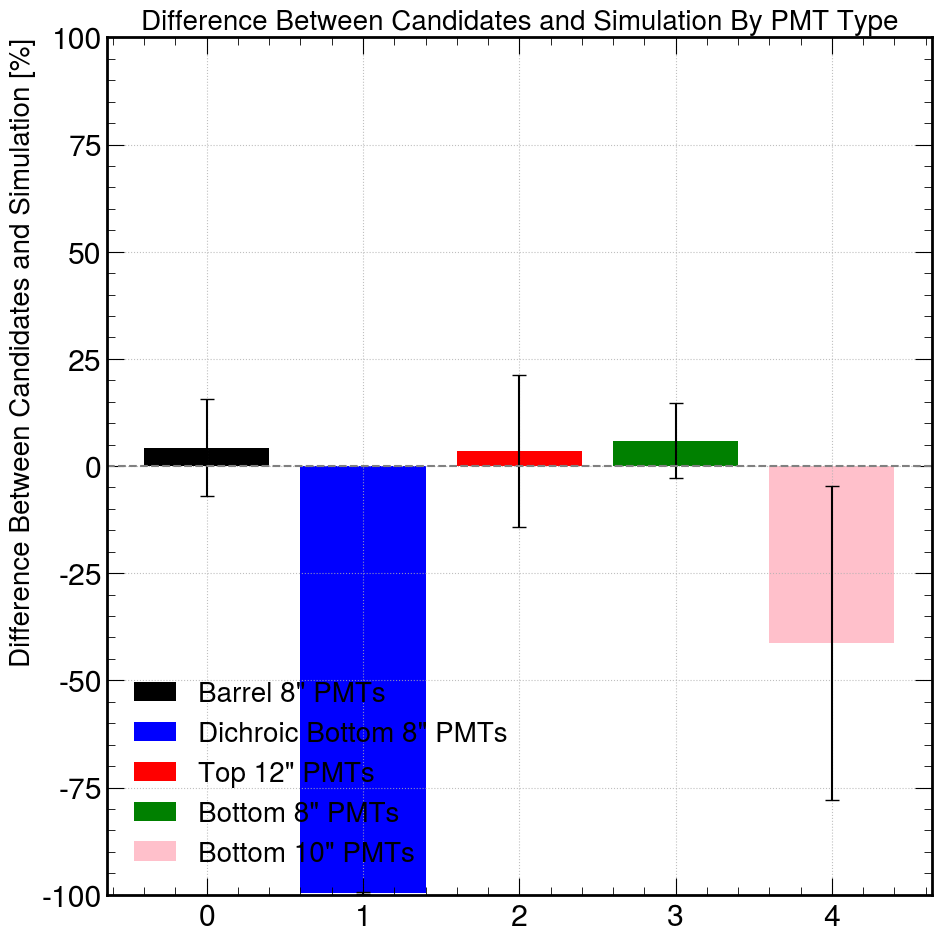

In [138]:
# These must be numpy arrays
diff = np.asarray(diff)
diff_err = np.asarray(diff_err)

group_labels = []
group_means = []
group_errors = []

for label, chs in groups.items():
    chs = np.asarray(chs)
    group_vals = diff[chs]
    group_errs = diff_err[chs]

    # Mask out NaNs for safe averaging
    valid = ~np.isnan(group_vals)
    if np.sum(valid) == 0:
        continue  # skip groups with no valid data

    group_mean = np.mean(group_vals[valid])
    group_error = np.std(group_vals[valid])#np.sqrt(np.sum(group_errs[valid]**2)) / np.sum(valid)  # avg err

    group_labels.append(label)
    group_means.append(group_mean)
    group_errors.append(group_error)


bar_colors = [colors[l] for l in group_labels]

# Plotting
plt.figure(figsize=(10,10))
x = list(range(len(group_labels)))  # numeric x-axis positions

for i in range(len(group_labels)):
    plt.bar(x[i], group_means[i], yerr=group_errors[i], capsize=5,
            color=bar_colors[i], label=group_labels[i])
# plt.bar(group_labels, group_means, yerr=group_errors, capsize=5, color=bar_colors)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Difference Between Candidates and Simulation [%]", fontsize=20)
plt.title("Difference Between Candidates and Simulation By PMT Type", fontsize=20)
# plt.xticks(rotation=45)
plt.legend(loc='lower left',fontsize=20)
plt.tight_layout()
plt.grid()
plt.ylim(-100,100)
plt.show()


In [139]:
# These must be numpy arrays
diff = np.asarray(diff)
diff_err = np.asarray(diff_err)

group_labels = []
group_means = []
group_errors = []

# Create a boolean mask of LCNs to keep
lcns = run.meta_data['pmtChannel']
keep_mask = ~np.isin(lcns, [1,2,3,4,5,6,7,8,9])

# Apply mask to all relevant arrays
lcns = lcns[keep_mask]
relative_diff = diff[keep_mask]
relative_diff_err = diff_err[keep_mask]


for label, chs in groups.items():
    chs = np.asarray(chs)
    group_vals = diff[chs]
    group_errs = diff_err[chs]

    # Mask out NaNs for safe averaging
    valid = ~np.isnan(group_vals)
    if np.sum(valid) == 0:
        continue  # skip groups with no valid data

    group_mean = np.mean(group_vals[valid])
    group_error = np.sqrt(np.sum(group_errs[valid]**2)) / np.sum(valid)  # avg err

    group_labels.append(label)
    group_means.append(group_mean)
    group_errors.append(group_error)


bar_colors = [colors[l] for l in group_labels]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(group_labels, group_means, yerr=group_errors, capsize=5, color=bar_colors)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Relative Difference (%)")
plt.title("Data - Simulation Comparison by PMT Group")
plt.tight_layout()
plt.grid()
plt.show()


for label, chs in groups.items():
    chs = np.asarray(chs)
    group_vals = diff[chs]
    group_errs = diff_err[chs]

    # Mask out NaNs for safe averaging
    valid = ~np.isnan(group_vals)
    if np.sum(valid) == 0:
        continue  # skip groups with no valid data

    group_mean = np.mean(group_vals[valid])
    group_error = np.sqrt(np.sum(group_errs[valid]**2)) / np.sum(valid)  # avg err

    group_labels.append(label)
    group_means.append(group_mean)
    group_errors.append(group_error)


bar_colors = [colors[l] for l in group_labels]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(group_labels, group_means, yerr=group_errors, capsize=5, color=bar_colors)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Relative Difference (%)")
plt.title("Data - Simulation Comparison by PMT Group")
plt.tight_layout()
plt.grid()
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed